# model

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skopt.space import Real
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.inspection import permutation_importance


# Step 1: Develop the Model

### 1.1 Load and Prepare the Data

First, you need to load your data from the Excel file and prepare it for analysis. This involves cleaning, possibly transforming the data, and splitting it into training and testing sets.

In [2]:
#pip install openpyxl

data = pd.read_excel('Data.xlsx')
data.head(2)
#print(data)

,Test number,Qf,Qs_m^3/hr,H_cm,ρs,Vfrontal_cm/s,Reo,F,Frdens,Location,Group,ABC,Qa/Qs,Position/H
0,1,1.92,0.1,23,1.006,4.637682,10613.600796,0.030875,0.379927,50,1,0.22,0.131974,2.173913
1,2,1.92,0.1,23,1.008,4.637682,10613.600796,0.030875,0.332830,50,1,0.34,0.203959,2.173913


In [3]:
# Display the statistical summary of specific columns in the dataframe
columns_to_describe = ['ρs', 'H_cm', 'Qf', 'Reo', 'F', 'Frdens', 'Location', 'ABC']
data_summary = data[columns_to_describe].describe()
data_summary

,ρs,H_cm,Qf,Reo,F,Frdens,Location,ABC
count,81.000000,81.000000,81.00000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,1.008000,24.000000,2.04000,11276.950846,0.030843,0.337165,75.000000,0.361864
std,0.001643,0.821584,0.09859,544.997679,0.002177,0.040796,20.539596,0.106226
min,1.006000,23.000000,1.92000,10613.600796,0.027245,0.264546,50.000000,0.140000
25%,1.006000,23.000000,1.92000,10613.600796,0.028965,0.299791,50.000000,0.300000
50%,1.008000,24.000000,2.04000,11276.950846,0.030776,0.332830,75.000000,0.350000
75%,1.010000,25.000000,2.16000,11940.300896,0.032586,0.374434,100.000000,0.420000
max,1.010000,25.000000,2.16000,11940.300896,0.034734,0.427418,100.000000,0.600000


In [4]:

data['ρs'] = pd.to_numeric(data['ρs'], errors='coerce')
data['H_cm'] = pd.to_numeric(data['H_cm'], errors='coerce')
data['Qf'] = pd.to_numeric(data['Qf'], errors='coerce')

data['Reo'] = pd.to_numeric(data['Reo'], errors='coerce')
data['Fr'] = pd.to_numeric(data['F'], errors='coerce')
data['Frdens'] = pd.to_numeric(data['Frdens'], errors='coerce')
data['Location'] = pd.to_numeric(data['Location'], errors='coerce')
data['Qa'] = pd.to_numeric(data['ABC'], errors='coerce')
data['Qa/Qs'] = pd.to_numeric(data['Qa/Qs'], errors='coerce')
data['Position/H'] = pd.to_numeric(data['Position/H'], errors='coerce')

# Drop rows where any of the converted columns is NaN
data.dropna(subset=['Reo', 'Fr', 'Frdens', 'Location', 'Qa', 'Qa/Qs', 'Position/H'], inplace=True)

### plot 

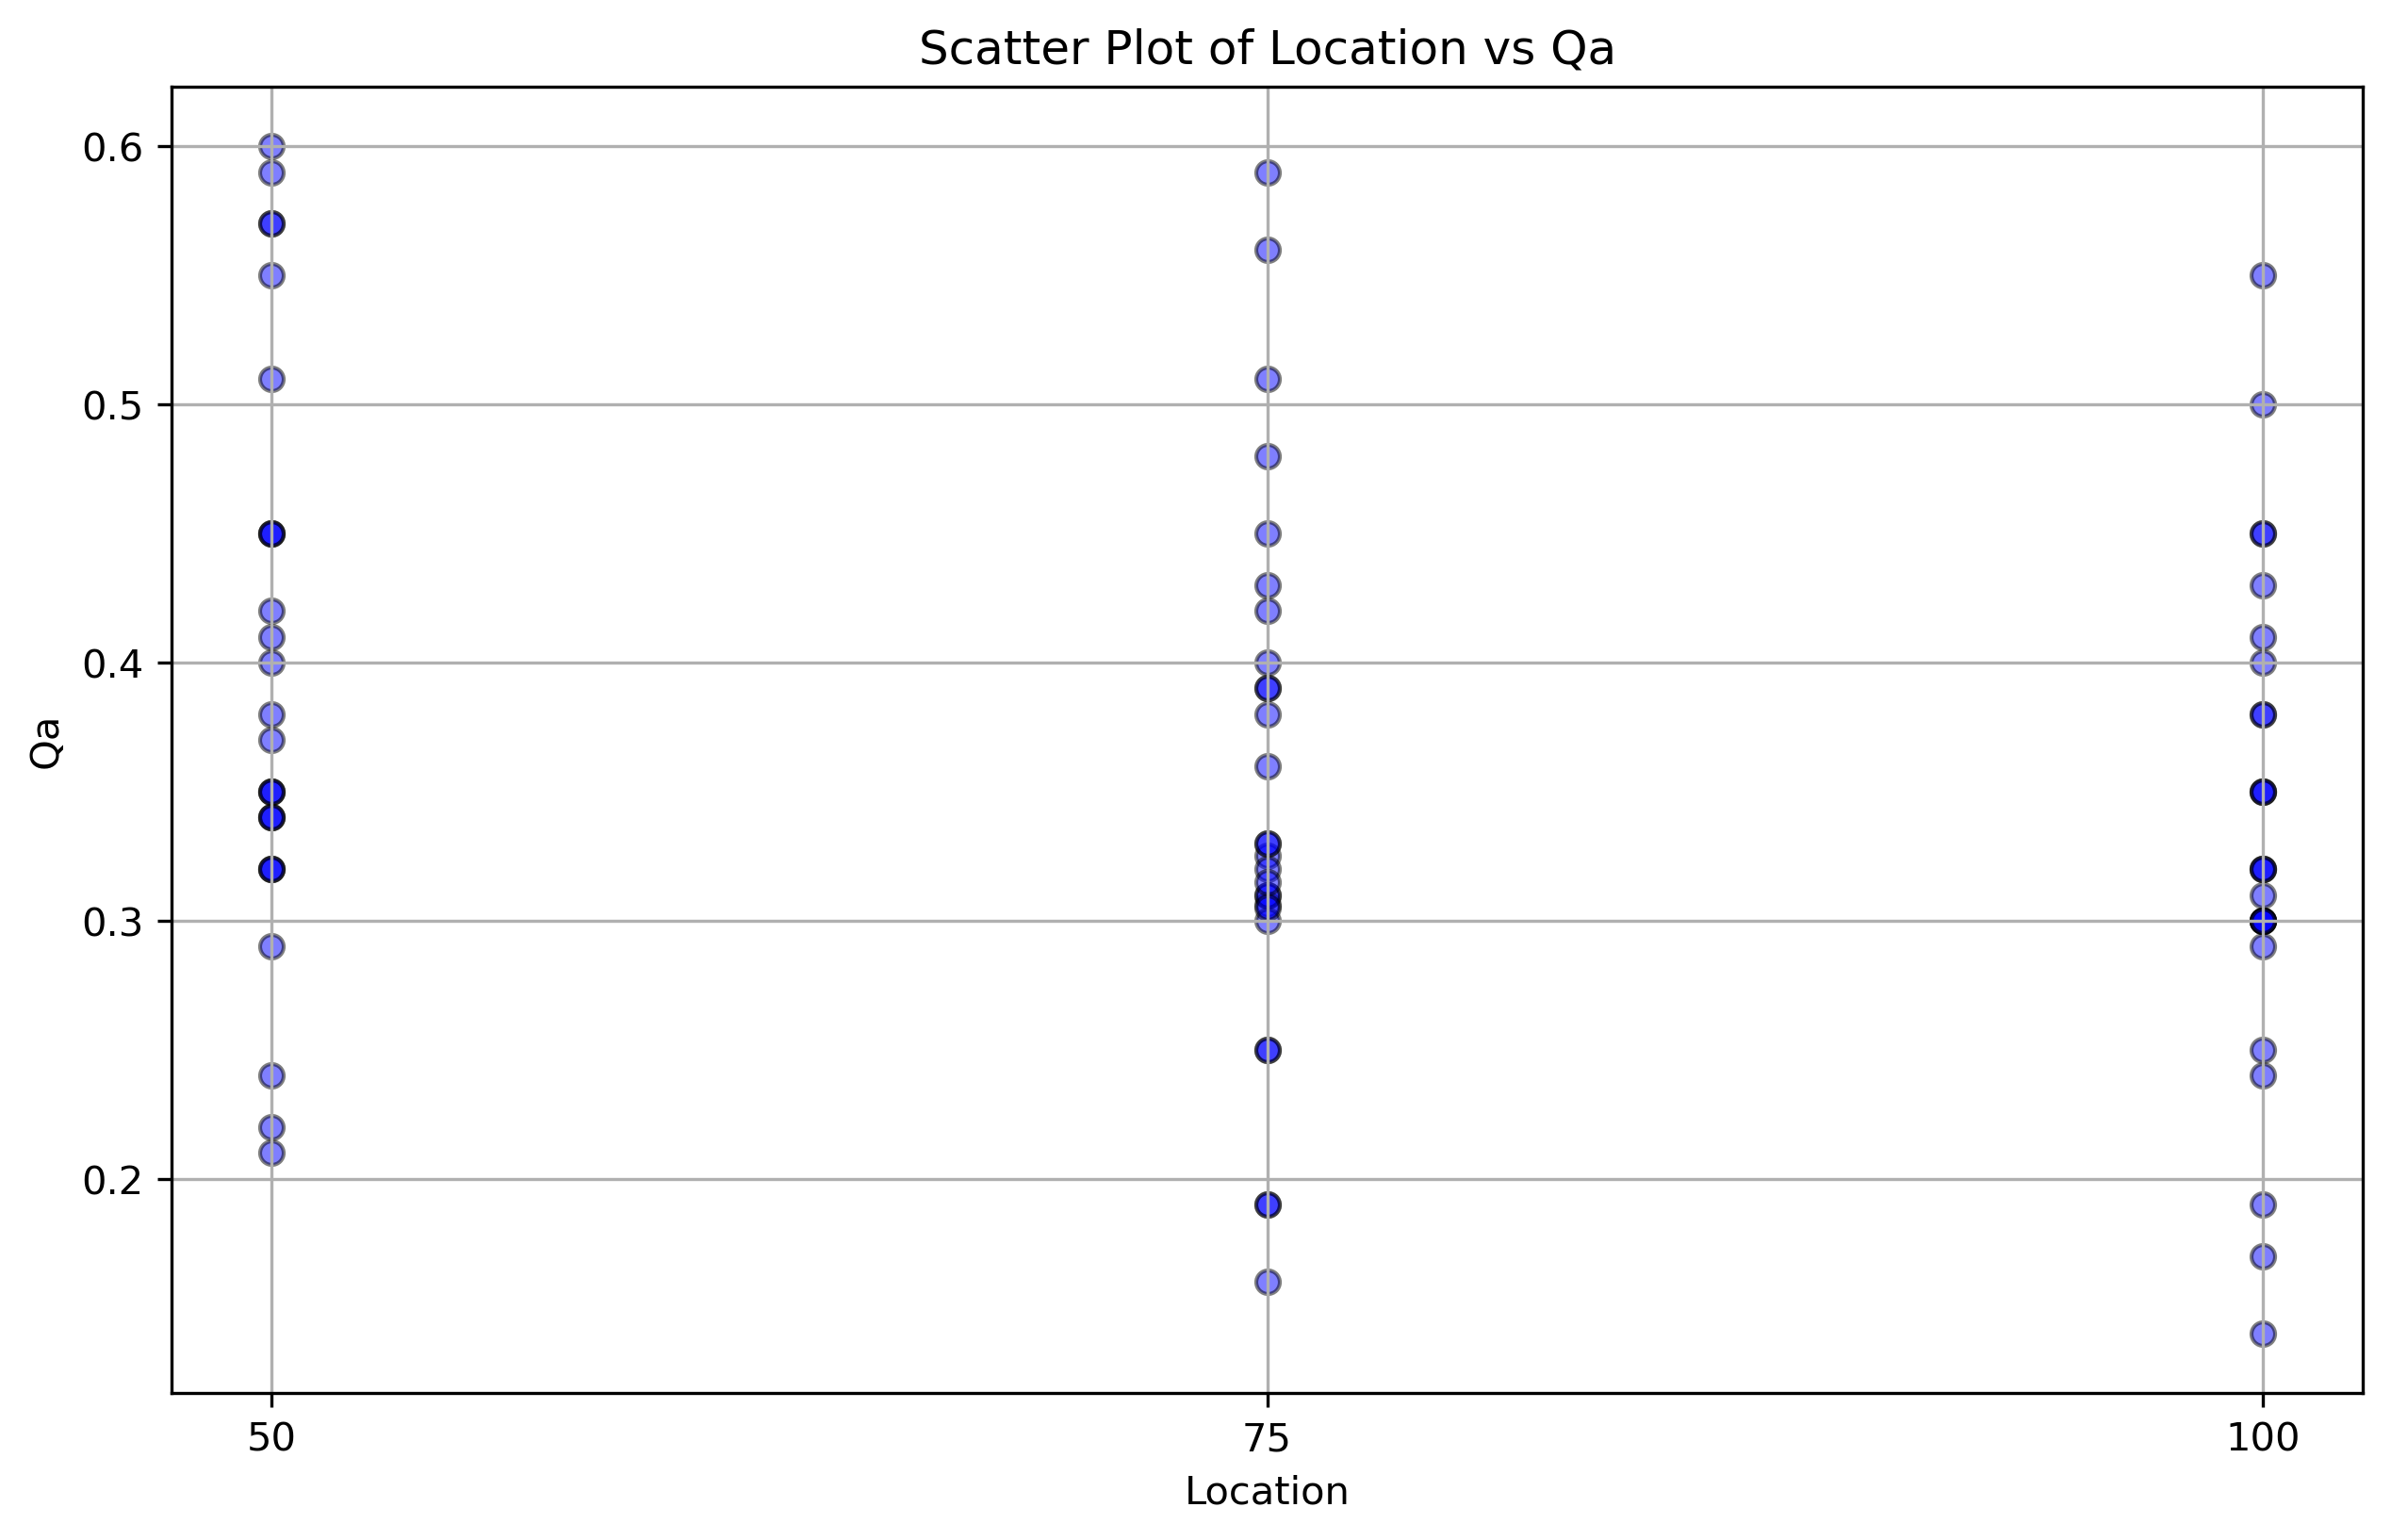

In [5]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(data['Location'], data['Qa'], c='blue', alpha=0.5, edgecolor='k')
plt.xlabel('Location')
plt.ylabel('Qa')
plt.title('Scatter Plot of Location vs Qa')
plt.grid(True)
plt.xticks([50, 75, 100])  # Ensuring only valid location values are shown on the x-axis
plt.show()


### 1.2  Train/Test the Model and Metric to evalute the model: 
Train two models, but remember L will be predicted from both yet is based on the same data.

# Step 3: Simulate Different Scenarios

### Model with three diferent test size: 0.2, 0.25 , and 0.3:

In [6]:
#!pip install xgboost

In [7]:


# Set the random seed for reproducibility
np.random.seed(42)

# Assuming data is already loaded into a DataFrame named 'data'

# Extract relevant columns
X = data[['ρs', 'H_cm', 'Qf', 'Reo', 'F', 'Frdens', 'Location']]
y = data[['ABC']]

# Adding polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7]
}

# Initialize list to store results for each test size
all_results = []

test_sizes = [0.2, 0.25, 0.3]

for test_size in test_sizes:
    # Train the model with best hyperparameters for each test size
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)
    base_model = XGBRegressor(random_state=42)
    model = MultiOutputRegressor(base_model)

    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Calculate metrics
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    # Store results for the current test size
    results = {
        'Test Size': test_size,
        'Train MAE ABC': train_mae,
        'Train RMSE ABC': train_rmse,
        'Train R-squared ABC': train_r2,
        'Test MAE ABC': test_mae,
        'Test RMSE ABC': test_rmse,
        'Test R-squared ABC': test_r2
    }
    all_results.append(results)

# Convert all results to a DataFrame
results_df = pd.DataFrame(all_results)

# Display the results DataFrame
results_df


,Test Size,Train MAE ABC,Train RMSE ABC,Train R-squared ABC,Test MAE ABC,Test RMSE ABC,Test R-squared ABC
0,0.20,0.001245,0.001627,0.999777,0.018953,0.023299,0.926148
1,0.25,0.000410,0.000588,0.999971,0.022934,0.030669,0.859212
2,0.30,0.005963,0.008729,0.993696,0.019661,0.024444,0.926072


## Final model Test size: 0.2

In [8]:



# Set the random seed for reproducibility
np.random.seed(42)

# Extract relevant columns
X = data[['ρs', 'H_cm', 'Qf', 'Reo', 'F', 'Frdens', 'Location']]
y = data[['ABC']]


# Adding polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)


# Define parameter grid for hyperparameter tuning
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7]
}

# Train the model with best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
base_model = XGBRegressor(random_state=42)
model = MultiOutputRegressor(base_model)



# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)


# Best model from grid search
best_model = grid_search.best_estimator_





# Generating predictions for locations 51 to 99
new_locations = np.arange(51, 100)
predictions = []

for loc in new_locations:
    for i in range(27):  # Using 27 tests for each location
        # Extract one of the original data rows and modify the location
        new_data = data.iloc[i][['ρs', 'H_cm', 'Qf', 'Reo', 'F', 'Frdens']].tolist() + [loc]
        new_data_poly = poly.transform([new_data])
        new_data_scaled = scaler.transform(new_data_poly)
        predicted_abc = best_model.predict(new_data_scaled)
        predictions.append({
            'ρs': new_data[0],
            'H_cm': new_data[1],
            'Qf': new_data[2],
            'Reo': new_data[3],
            'F': new_data[4],
            'Frdens': new_data[5],
            'Location': loc,
            'ABC': predicted_abc[0, 0]
        })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Save predictions to a file
predictions_file_path = 'Predictions_from_51_to_99.xlsx'
predictions_df.to_excel(predictions_file_path, index=False)

# Calculate metrics
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Initialize dictionary to store results
results = {
    'Model': ['XGBoost'],
    'Train MAE ABC': [train_mae],
    'Train RMSE ABC': [train_rmse],
    'Train R-squared ABC': [train_r2],
    'Test MAE ABC': [test_mae],
    'Test RMSE ABC': [test_rmse],
    'Test R-squared ABC': [test_r2]
}

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/ehsankahrizi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


,Model,Train MAE ABC,Train RMSE ABC,Train R-squared ABC,Test MAE ABC,Test RMSE ABC,Test R-squared ABC
0,XGBoost,0.001245,0.001627,0.999777,0.018953,0.023299,0.926148


### Sensivity of 'Reo', 'F', 'Frdens', 'Location' to 'ABC':

          Importance
Frdens      0.902036
Location    0.049010
Reo         0.037776
F           0.011177


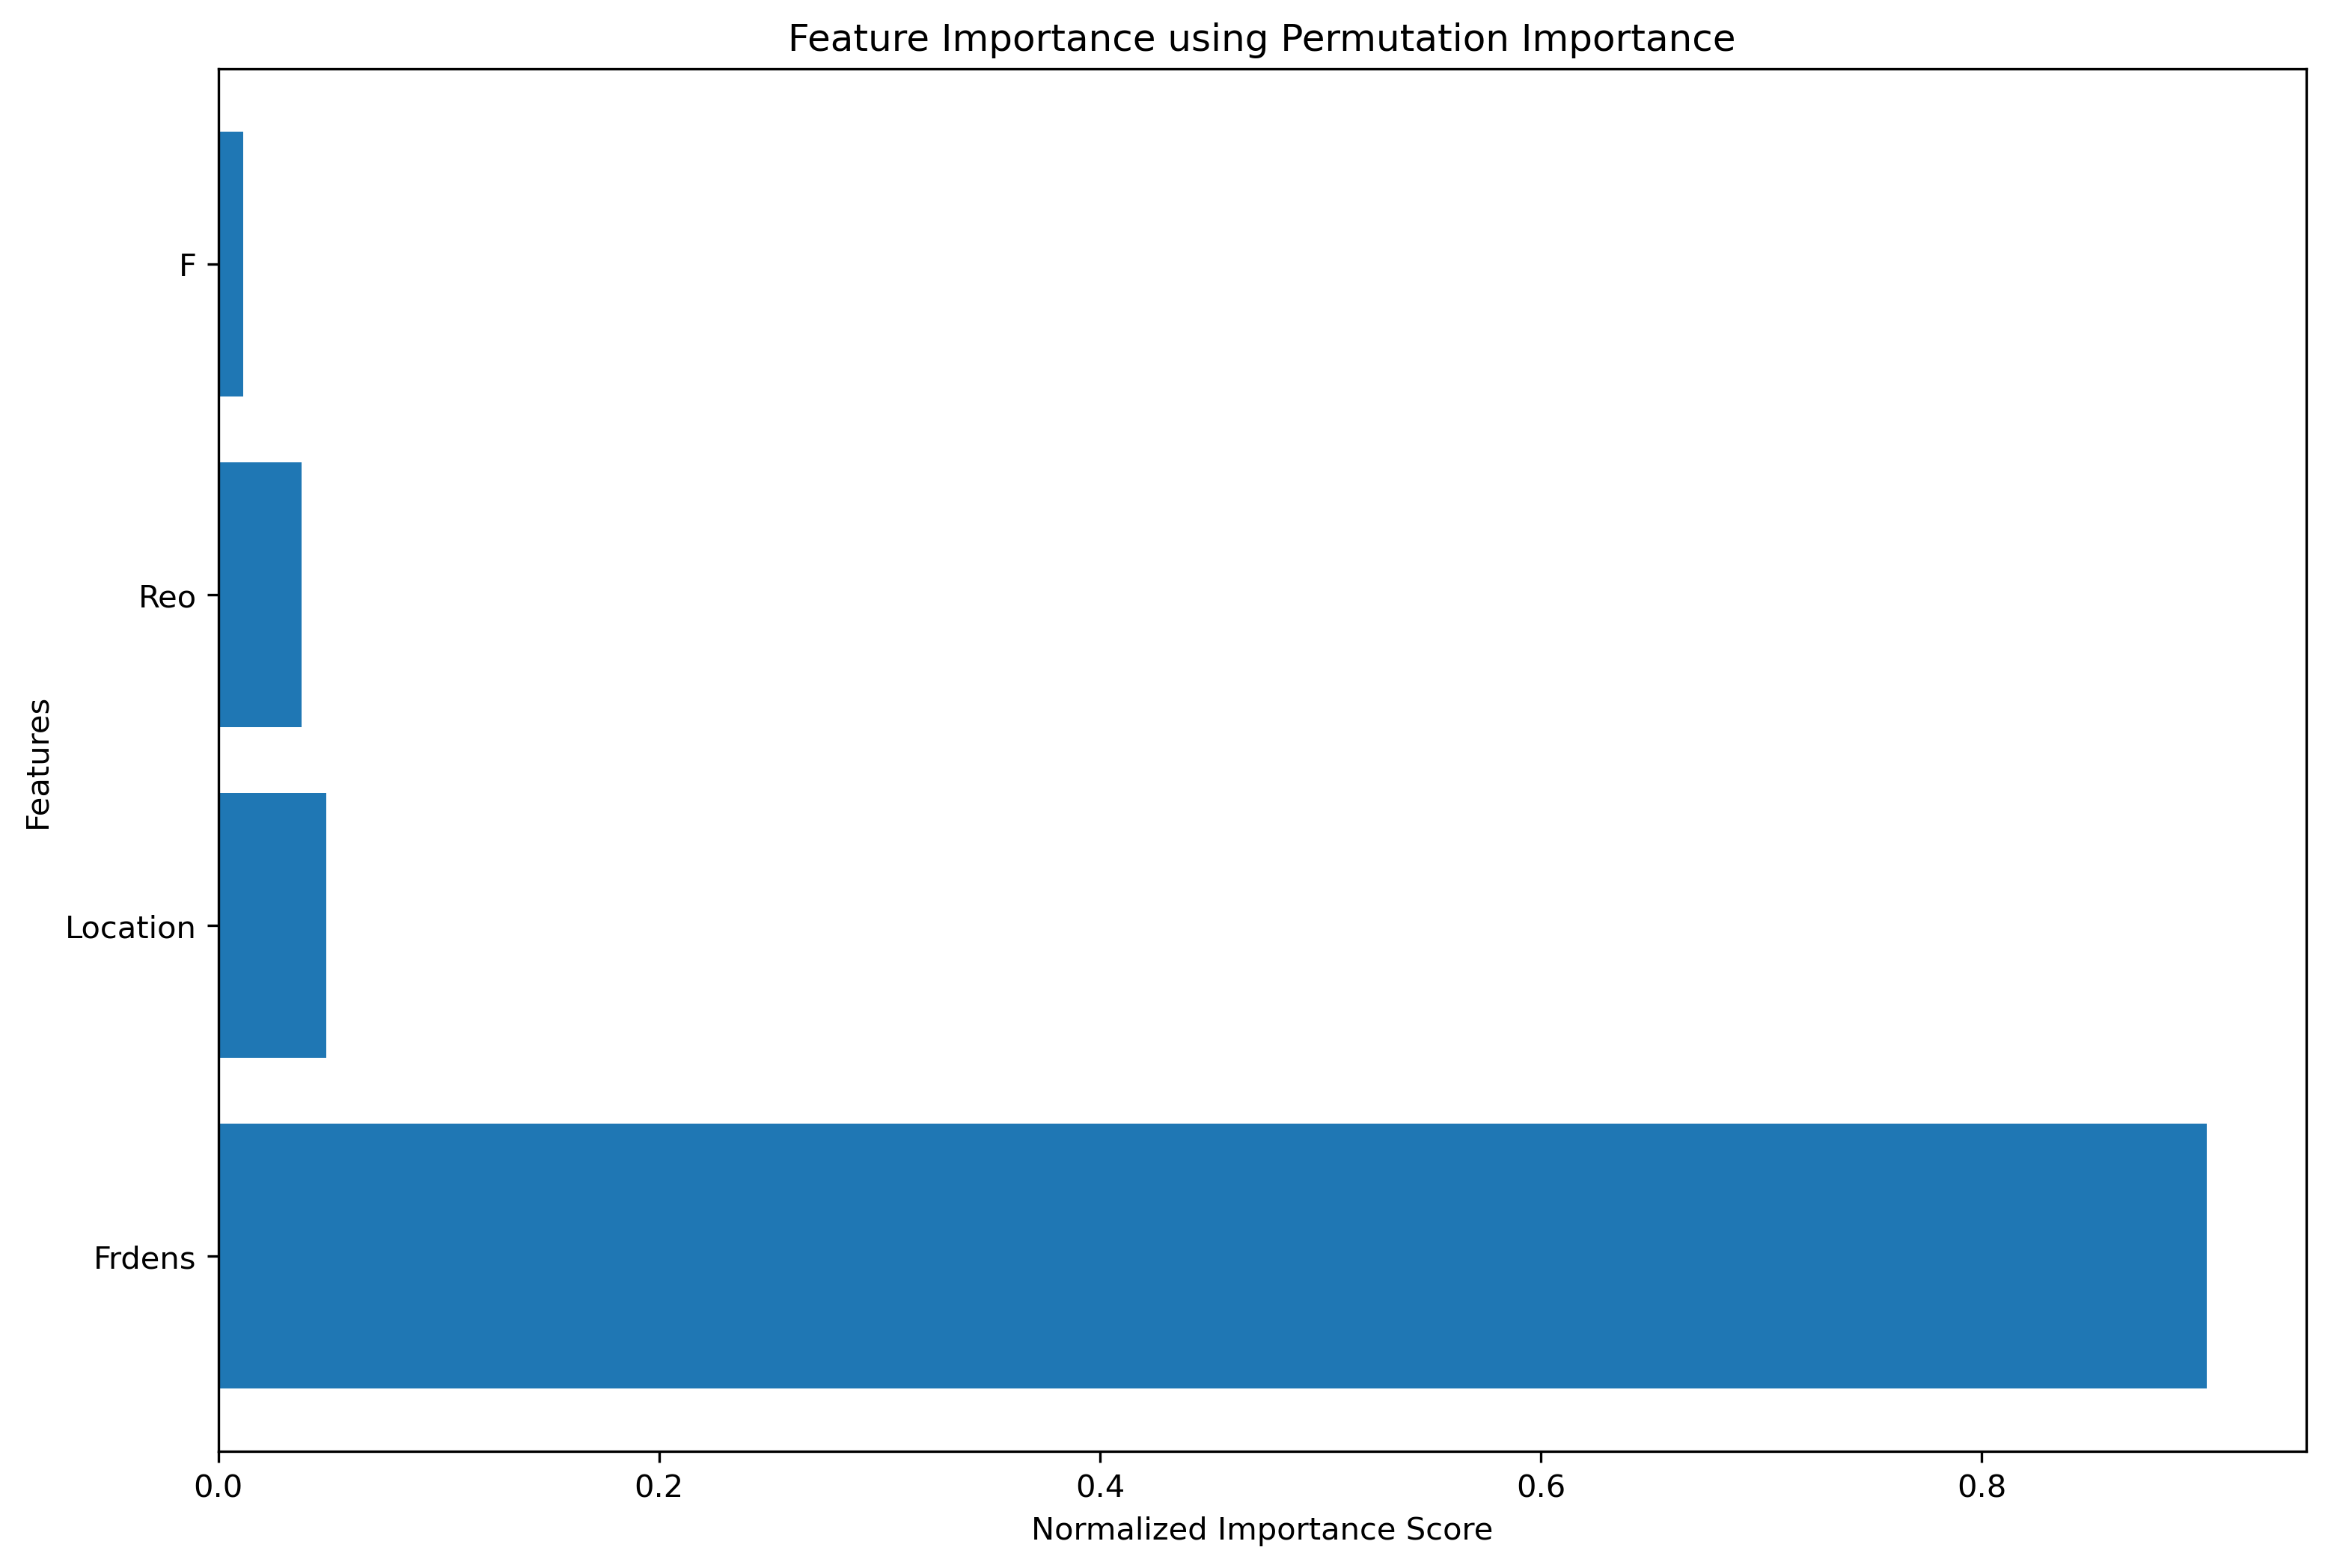

In [9]:


# Set the random seed for reproducibility
np.random.seed(42)

# Assuming 'data' is your DataFrame containing the data
# Extract relevant columns
X = data[['Reo', 'F', 'Frdens', 'Location']]
y = data[['ABC']]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Train the model with best hyperparameters
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = XGBRegressor(random_state=42)

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Calculate metrics
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Initialize dictionary to store results
results = {
    'Model': ['XGBoost'],
    'Train MAE ABC': [train_mae],
    'Train RMSE ABC': [train_rmse],
    'Train R-squared ABC': [train_r2],
    'Test MAE ABC': [test_mae],
    'Test RMSE ABC': [test_rmse],
    'Test R-squared ABC': [test_r2]
}

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

# Sensitivity analysis using permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_scores = result.importances_mean

# Normalize the importance scores
normalized_importance_scores = importance_scores / np.sum(importance_scores)

# Create DataFrame for importance scores
importance_df = pd.DataFrame(normalized_importance_scores, index=X.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

# Display the importance DataFrame
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8), dpi= 300)
plt.barh(importance_df.index, importance_df['Importance'])
plt.xlabel('Normalized Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance using Permutation Importance')
plt.show()


### Actual vs. Predicted value:

In [10]:
# Ensure y_test is a DataFrame and reset index
y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ['Actual_ABC']
y_test_df.reset_index(drop=True, inplace=True)

# Check if y_test contains any NaN values
print(y_test_df.isna().sum())  # This will print the count of NaN values in each column

# Generate predictions for the test set
y_test_pred = best_model.predict(X_test)

# Create a DataFrame for predicted values of the test set
predicted_values_df = pd.DataFrame(y_test_pred, columns=['Predicted_ABC'])
predicted_values_df.reset_index(drop=True, inplace=True)

# Combine both DataFrames to compare actual and predicted values
comparison_df = pd.concat([y_test_df, predicted_values_df], axis=1)


print("\nComparison DataFrame:")
comparison_df


Actual_ABC    0
dtype: int64

Comparison DataFrame:


,Actual_ABC,Predicted_ABC
0,0.310,0.307691
1,0.220,0.235813
2,0.400,0.382151
3,0.330,0.370302
4,0.240,0.190519
5,0.325,0.305920
6,0.320,0.336062
7,0.380,0.354580
8,0.370,0.435268
9,0.320,0.272896


In [11]:
data = pd.read_excel('Predictions_from_51_to_99.xlsx')
data.head(2)

,ρs,H_cm,Qf,Reo,F,Frdens,Location,ABC
0,1.006,23,1.92,10613.600796,0.030875,0.379927,51,0.238784
1,1.008,23,1.92,10613.600796,0.030875,0.332830,51,0.342072


In [12]:
# Load the predictions dataset
predictions_df = pd.read_excel('Predictions_from_51_to_99.xlsx')

# Convert ABC to numeric if it's not already
predictions_df['ABC'] = pd.to_numeric(predictions_df['ABC'], errors='coerce')

# Calculate the average value of ABC for rows where the Location is the same
results_df = predictions_df.groupby('Location')['ABC'].mean().reset_index()

# Convert Location to numeric if it's not already
results_df['Location'] = pd.to_numeric(results_df['Location'], errors='coerce')

# Inspect the average_abc DataFrame to ensure it is correct
results_df.head()

,Location,ABC
0,51,0.390969
1,52,0.390650
2,53,0.386527
3,54,0.379301
4,55,0.379237


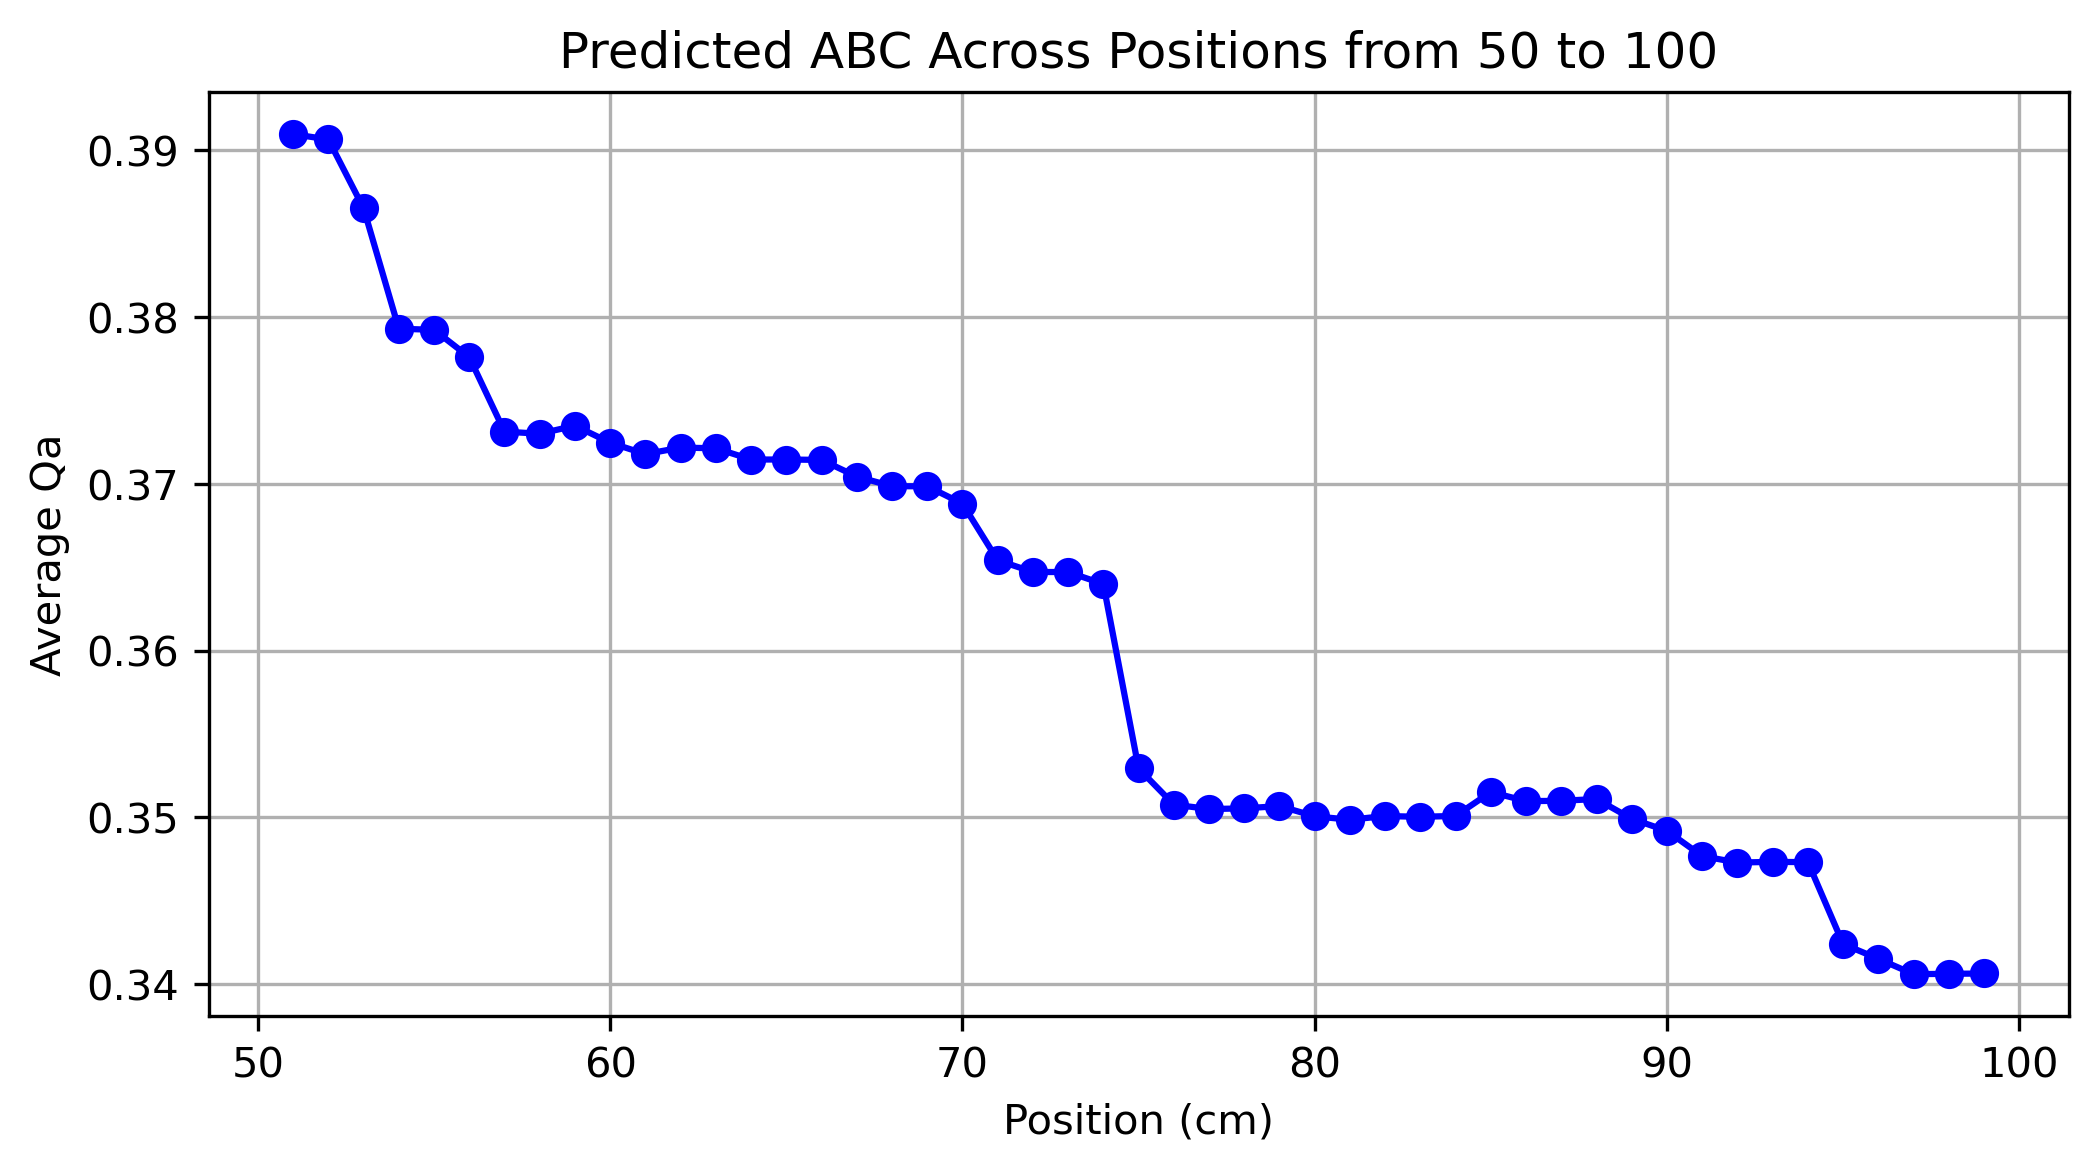

In [13]:
# Plotting the average ABC values by Location
plt.figure(figsize=(8, 4), dpi=300) 
plt.plot(results_df['Location'], results_df['ABC'], marker='o', linestyle='-', color='b')
plt.title('Predicted ABC Across Positions from 50 to 100')  # Title of the plot
plt.xlabel('Position (cm)')  # X-axis label
plt.ylabel('Average Qa')  # Y-axis label
plt.grid(True)
plt.show()

# Step 4: Calculating Non-dimention ratio:

### A = Position/H_avg
### B = Qa_Predicted (avg)/Qs_avg

In [14]:

# Add a new column that is Position divided by H_avg
# A = Position/H_avg
results_df['A'] = results_df['Location'] / 24

# B = Qa_Predicted (avg)/Qs_avg
results_df['B'] = results_df['ABC'] / (0.1*16.67) # 16.67 is converting coffecient from the m^3/h to lit/min

# Display the updated DataFrame to verify the new column
results_df.head()

,Location,ABC,A,B
0,51,0.390969,2.125000,0.234534
1,52,0.390650,2.166667,0.234343
2,53,0.386527,2.208333,0.231870
3,54,0.379301,2.250000,0.227535
4,55,0.379237,2.291667,0.227497


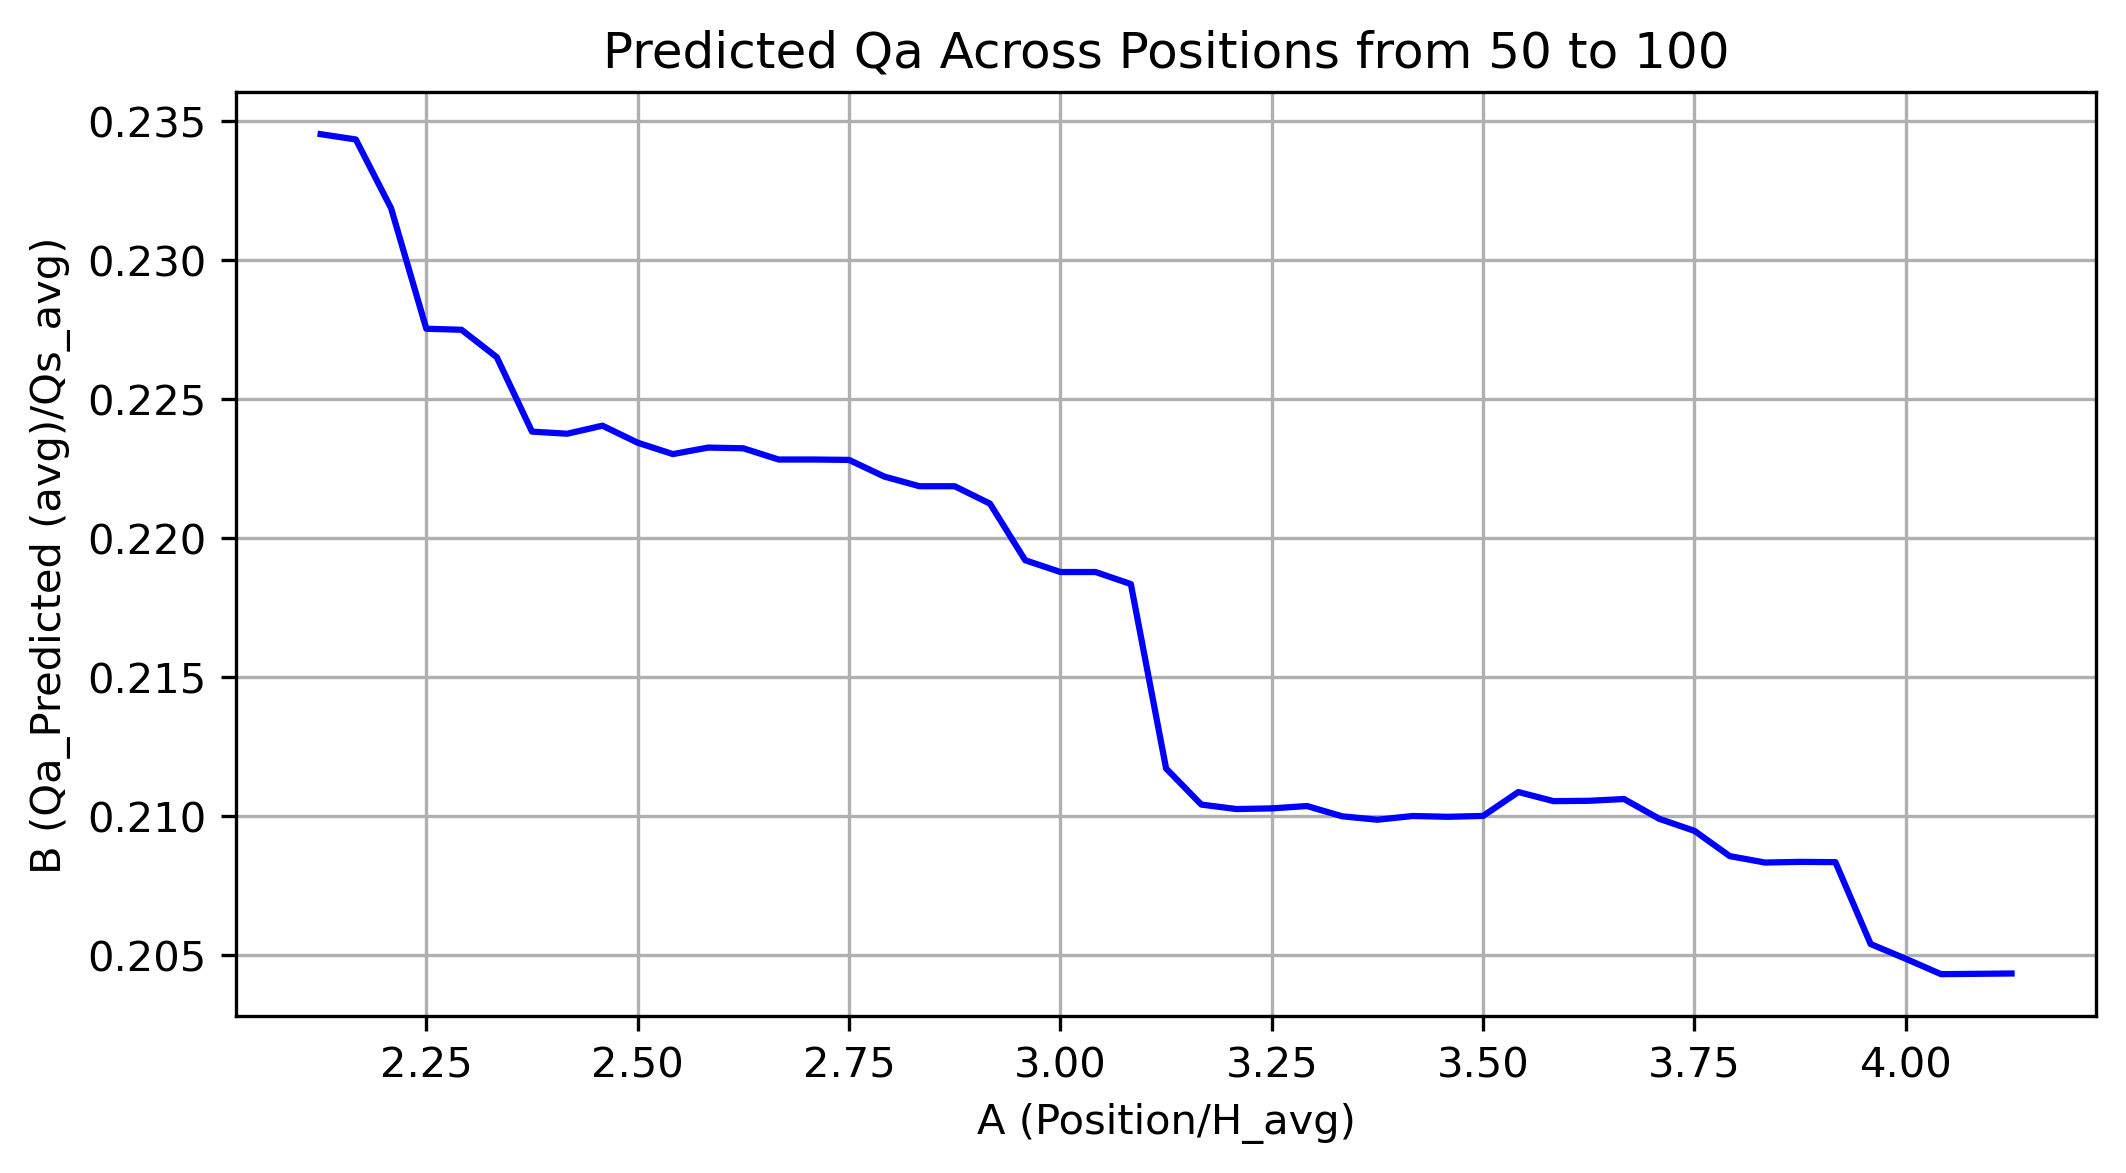

In [15]:
plt.figure(figsize=(8, 4), dpi=300) 
plt.plot(results_df['A'], results_df['B'], 
         #marker='o', 
         linestyle='-', 
         color='b'
        )
plt.title('Predicted Qa Across Positions from 50 to 100')  # Title of the plot
plt.xlabel('A (Position/H_avg)')  # X-axis label
plt.ylabel('B (Qa_Predicted (avg)/Qs_avg)')  # Y-axis label
plt.grid(True)  # Enable grid for easier visualization
plt.show()  # Display the plot

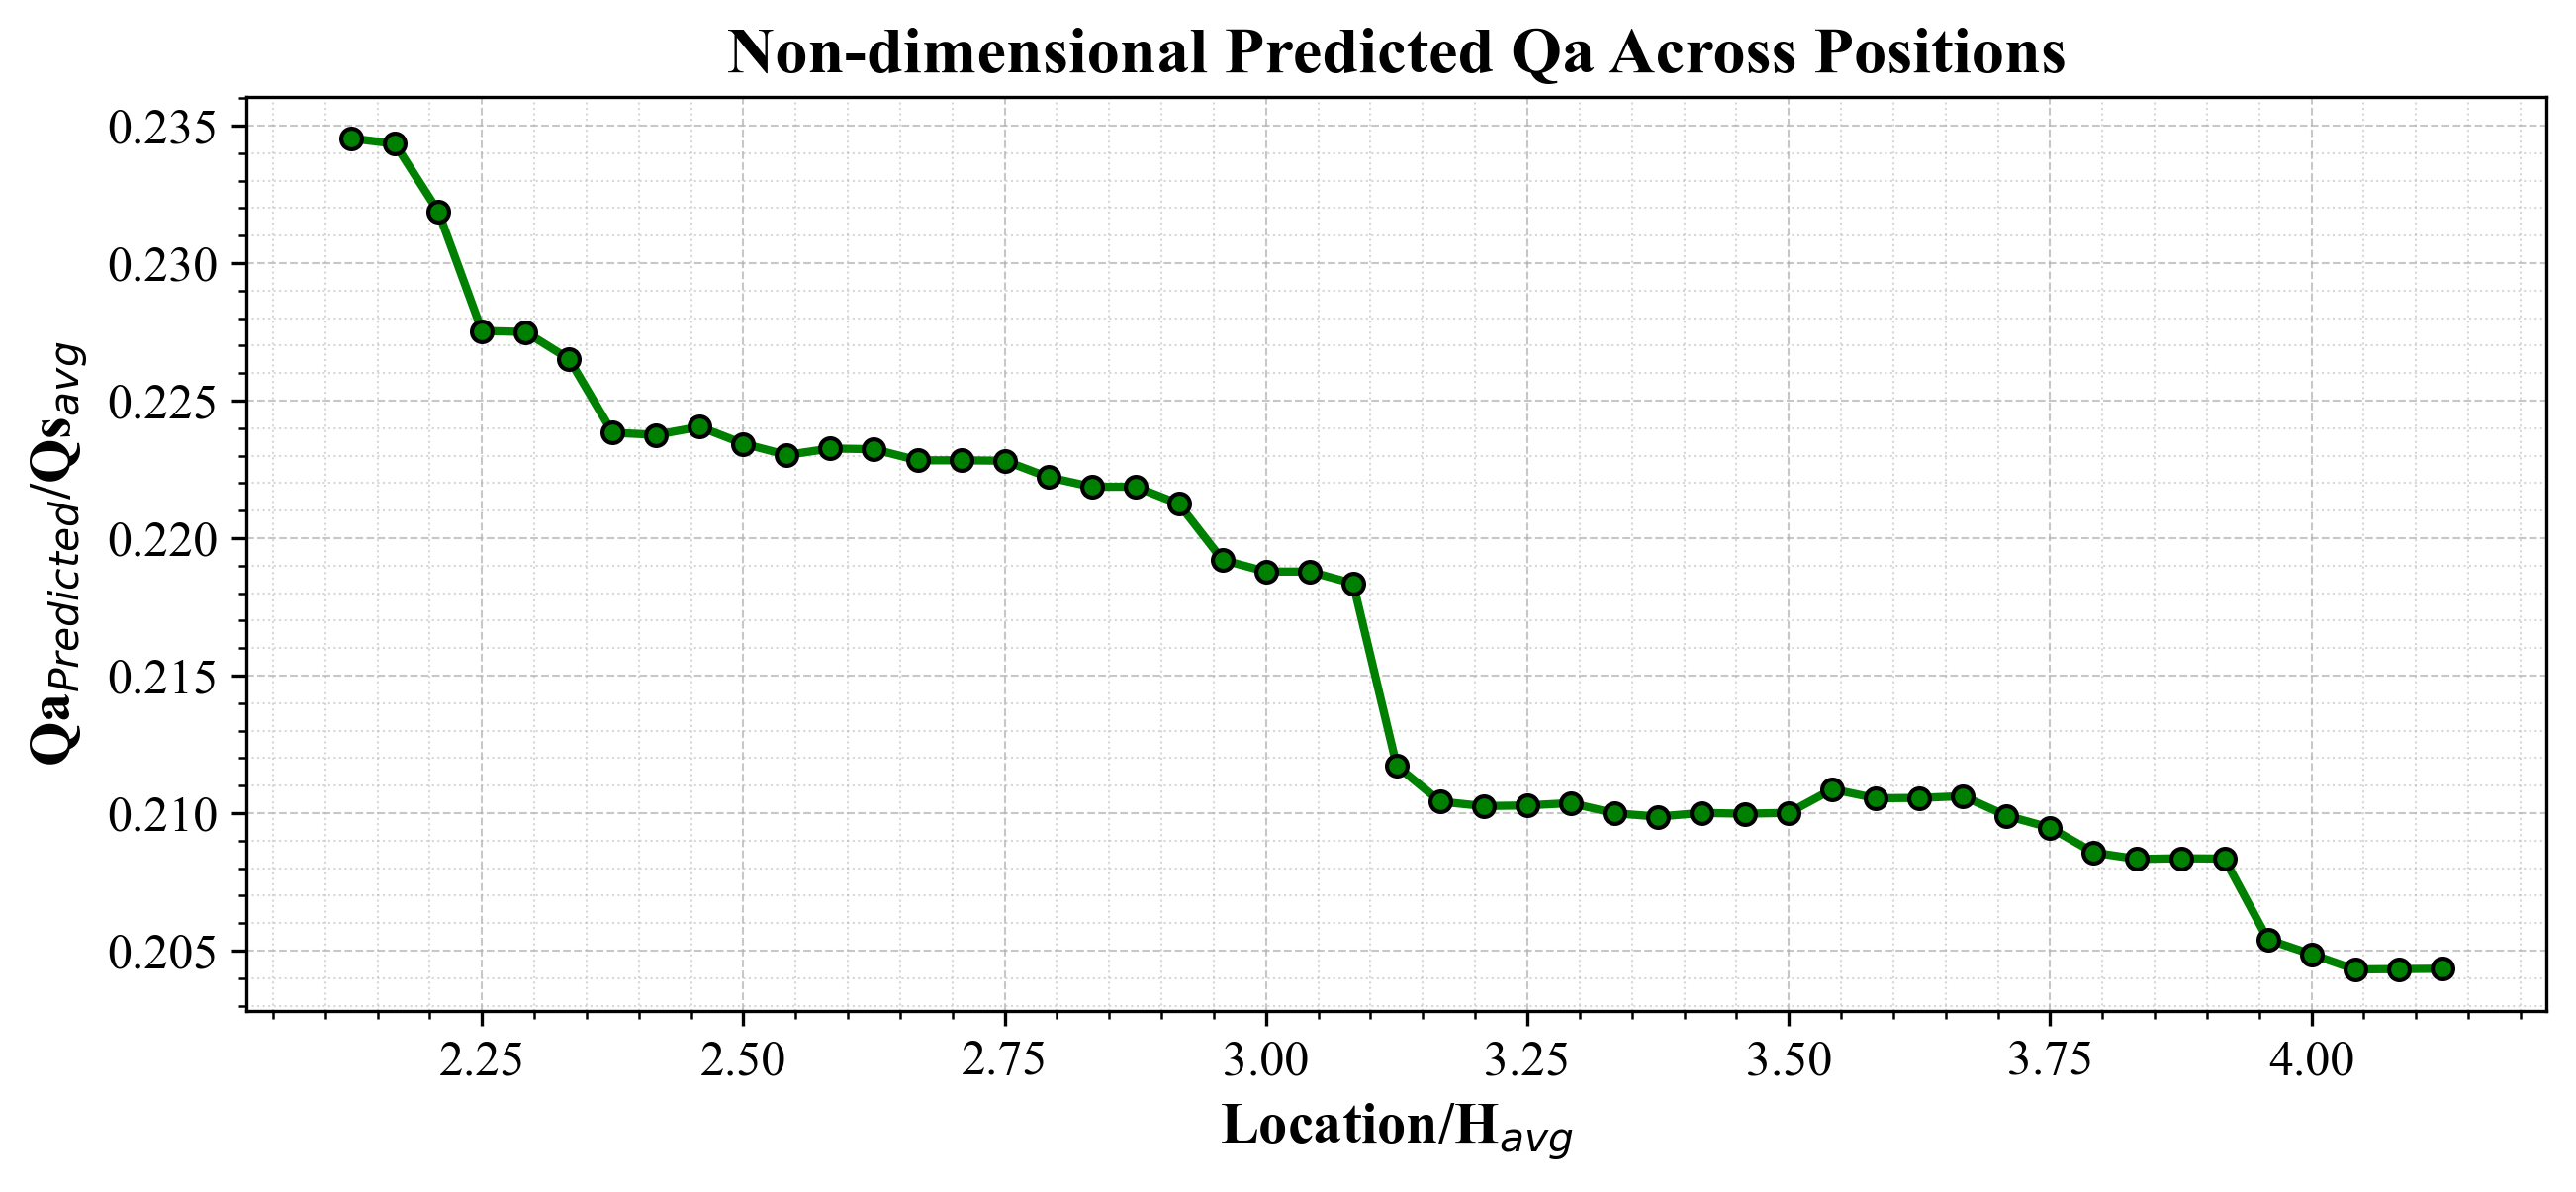

In [16]:
import matplotlib.pyplot as plt

# Create the figure and axis with specified size and resolution
plt.figure(figsize=(10, 4), dpi=300)

# Plot the data with enhancements
plt.plot(results_df['A'], results_df['B'], 
         linestyle='-', 
         color='g', 
         linewidth=2,  # Thicker line for better visibility
         marker='o',  # Add markers at data points
         markersize=5,  # Size of markers
         markerfacecolor='g',  # Fill color of the markers
         markeredgewidth=1,  # Edge width of the markers
         markeredgecolor='k'  # Edge color of the markers
        )

# Title of the plot
plt.title('Non-dimensional Predicted Qa Across Positions', fontsize=16, fontname='Times New Roman', fontweight='bold')

# X-axis label with subscript
plt.xlabel('Location/H$_{avg}$', fontsize=14, fontname='Times New Roman', fontweight='bold')

# Y-axis label with subscript
plt.ylabel('Qa$_{Predicted}$/Qs$_{avg}$', fontsize=14, fontname='Times New Roman', fontweight='bold')

# Enable grid with customization
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set the font for the tick labels
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Add minor ticks for better precision
plt.minorticks_on()

# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Display the plot
plt.show()


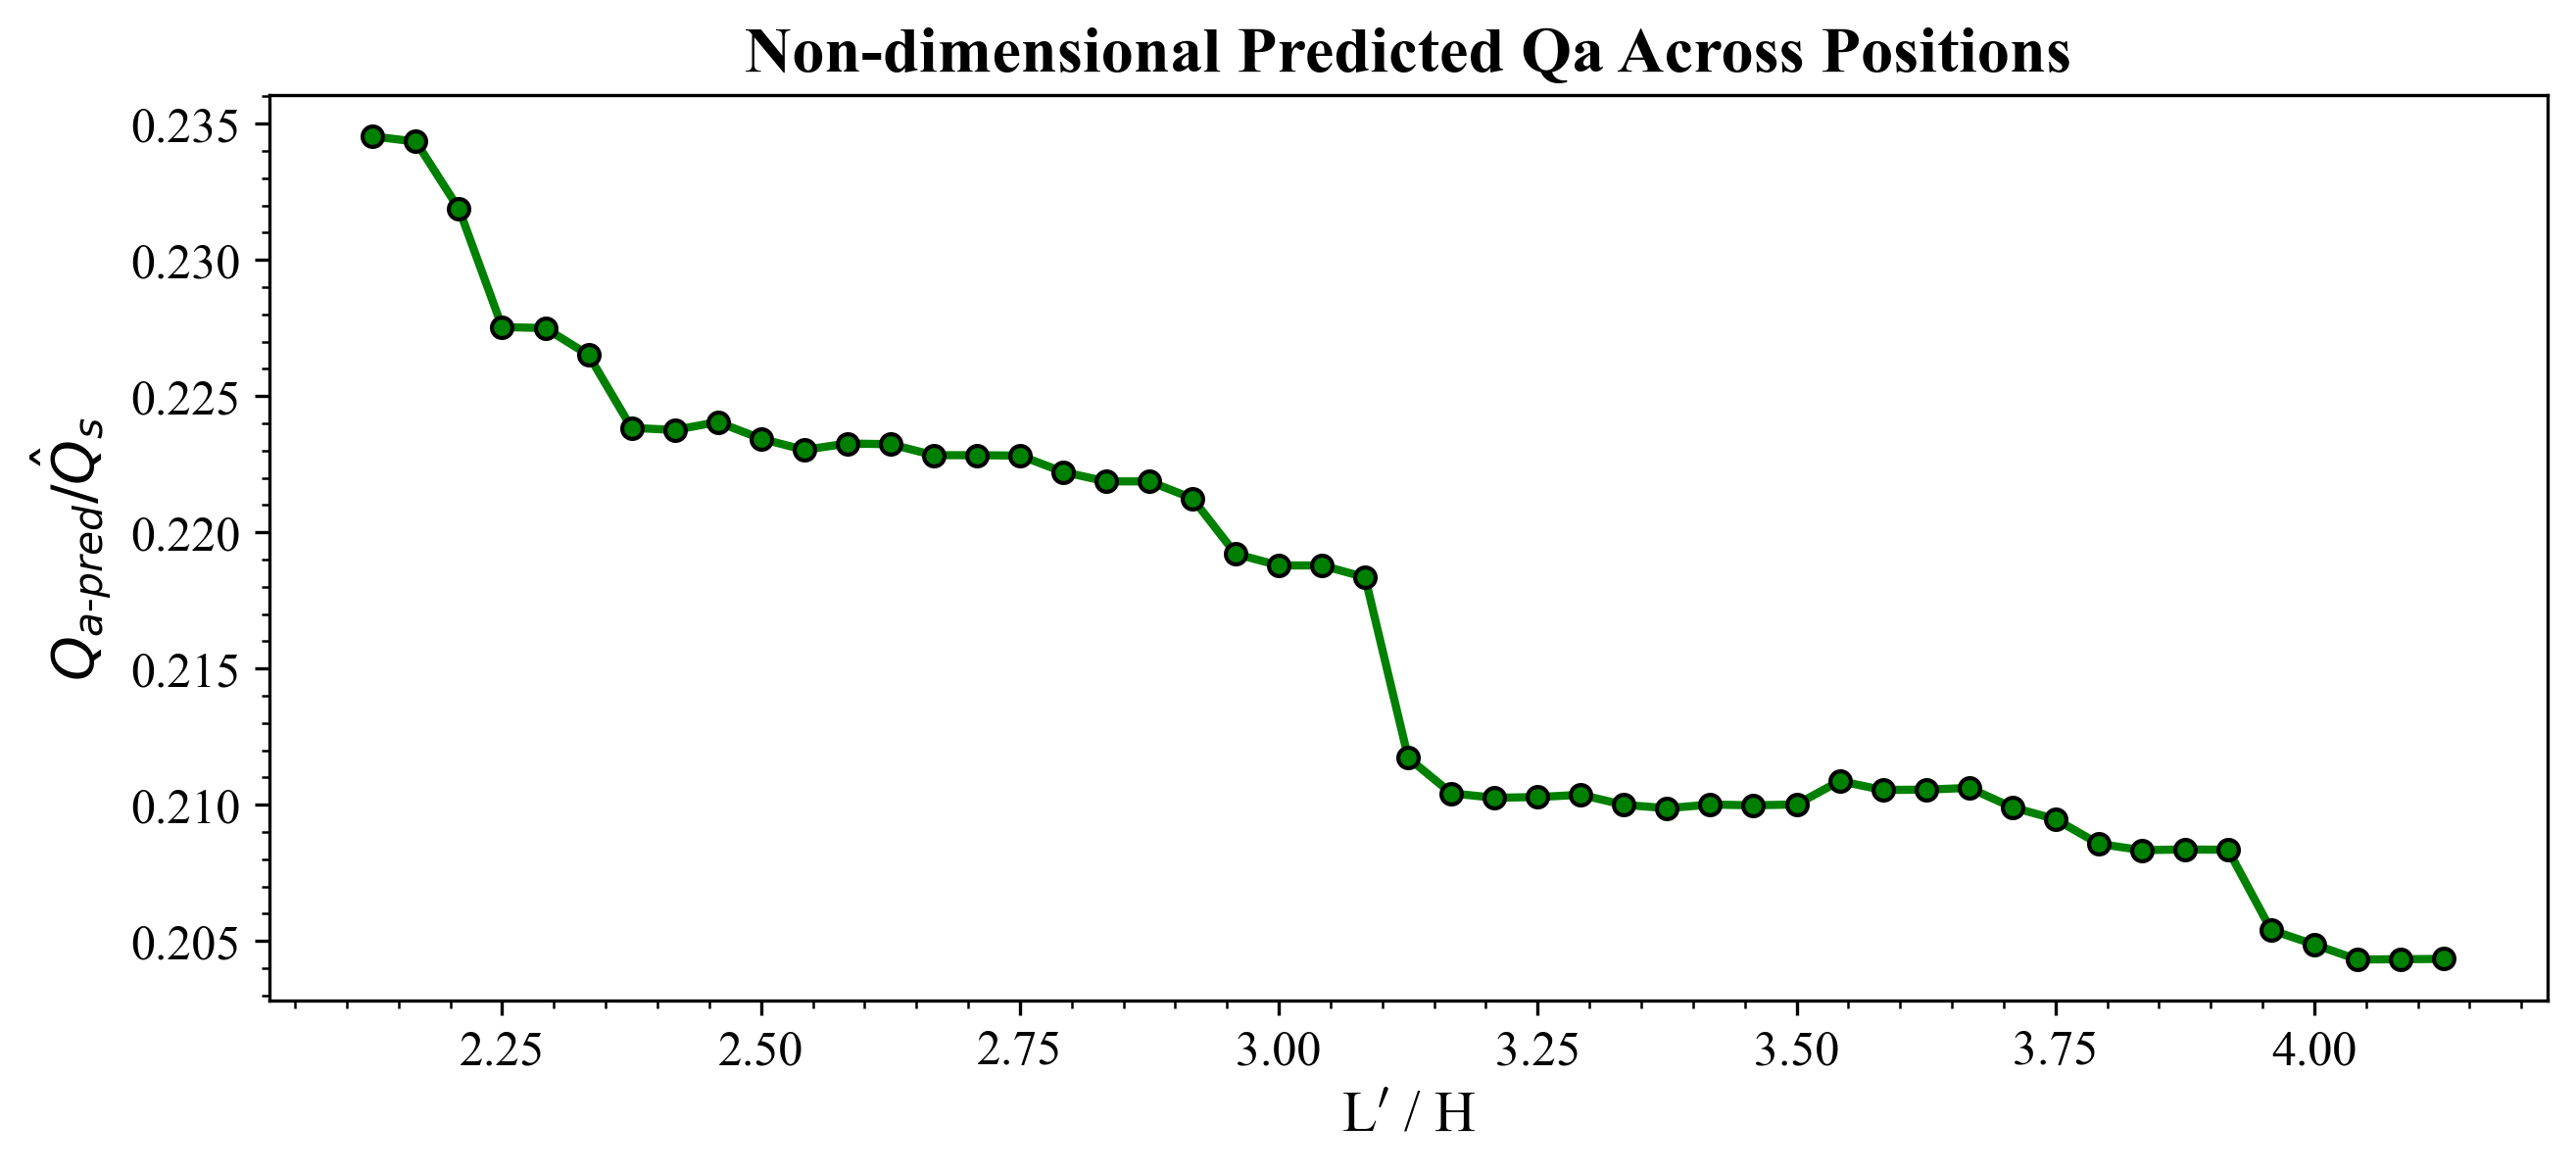

In [17]:
import matplotlib.pyplot as plt

# Create the figure and axis with specified size and resolution
plt.figure(figsize=(10, 4), dpi=300)

# Plot the data with enhancements
plt.plot(results_df['A'], results_df['B'], 
         linestyle='-', 
         color='g', 
         linewidth=2,  # Thicker line for better visibility
         marker='o',  # Add markers at data points
         markersize=5,  # Size of markers
         markerfacecolor='g',  # Fill color of the markers
         markeredgewidth=1,  # Edge width of the markers
         markeredgecolor='k'  # Edge color of the markers
        )

# Title of the plot
plt.title('Non-dimensional Predicted Qa Across Positions', fontsize=16, fontname='Times New Roman', fontweight='bold')

# X-axis label with L' and h
plt.xlabel("L$'$ / H", fontsize=14, fontname='Times New Roman'
          # , fontweight='bold'
          )

# Y-axis label with Q a-pred / Q hat s (corrected)
plt.ylabel('$Q_{a\\text{-}pred}/\\hat{Q}_s$', fontsize=14, fontname='Times New Roman', fontweight='bold')


# Enable grid with customization
#plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set the font for the tick labels
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Add minor ticks for better precision
plt.minorticks_on()

# Customize the minor grid
#plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Display the plot
plt.show()




# Step 5: Decision Making
Analyze results to optimize Location and Qa.

 ### Normalize the Y and X to be in range 0~1 (based on the eq 6 and 7):

In [18]:
# Normalize the metrics (scale between 0 and 1)
results_df['Normalized Position/H_avg'] = (results_df['A'] - results_df['A'].min()) / (results_df['A'].max() - results_df['A'].min())
results_df['Normalized Qa_Predicted (avg)/Qs_avg'] = (results_df['B'] - results_df['B'].min()) / (results_df['B'].max() - results_df['B'].min())
results_df.head()

,Location,ABC,A,B,Normalized Position/H_avg,Normalized Qa_Predicted (avg)/Qs_avg
0,51,0.390969,2.125000,0.234534,0.000000,1.000000
1,52,0.390650,2.166667,0.234343,0.020833,0.993668
2,53,0.386527,2.208333,0.231870,0.041667,0.911817
3,54,0.379301,2.250000,0.227535,0.062500,0.768373
4,55,0.379237,2.291667,0.227497,0.083333,0.767115


 ### Calculation Desision Score (based on the eq 8):

In [19]:


results_df['Decision Score'] = ((results_df['Normalized Position/H_avg'])) + ((results_df['Normalized Qa_Predicted (avg)/Qs_avg']))

#results_df['Decision Score'] = ((results_df['Position/H_avg'])) + ((results_df['Qa_Predicted (avg)/Qs_avg']))



# Find the position with the lowest decision score
optimal_position = results_df.loc[results_df['Decision Score'].idxmin()]

print("Optimal Position for Installing ABC:")

print(optimal_position)

Optimal Position for Installing ABC:
Location                                76.000000
ABC                                      0.350765
A                                        3.166667
B                                        0.210417
Normalized Position/H_avg                0.520833
Normalized Qa_Predicted (avg)/Qs_avg     0.201888
Decision Score                           0.722721
Name: 25, dtype: float64


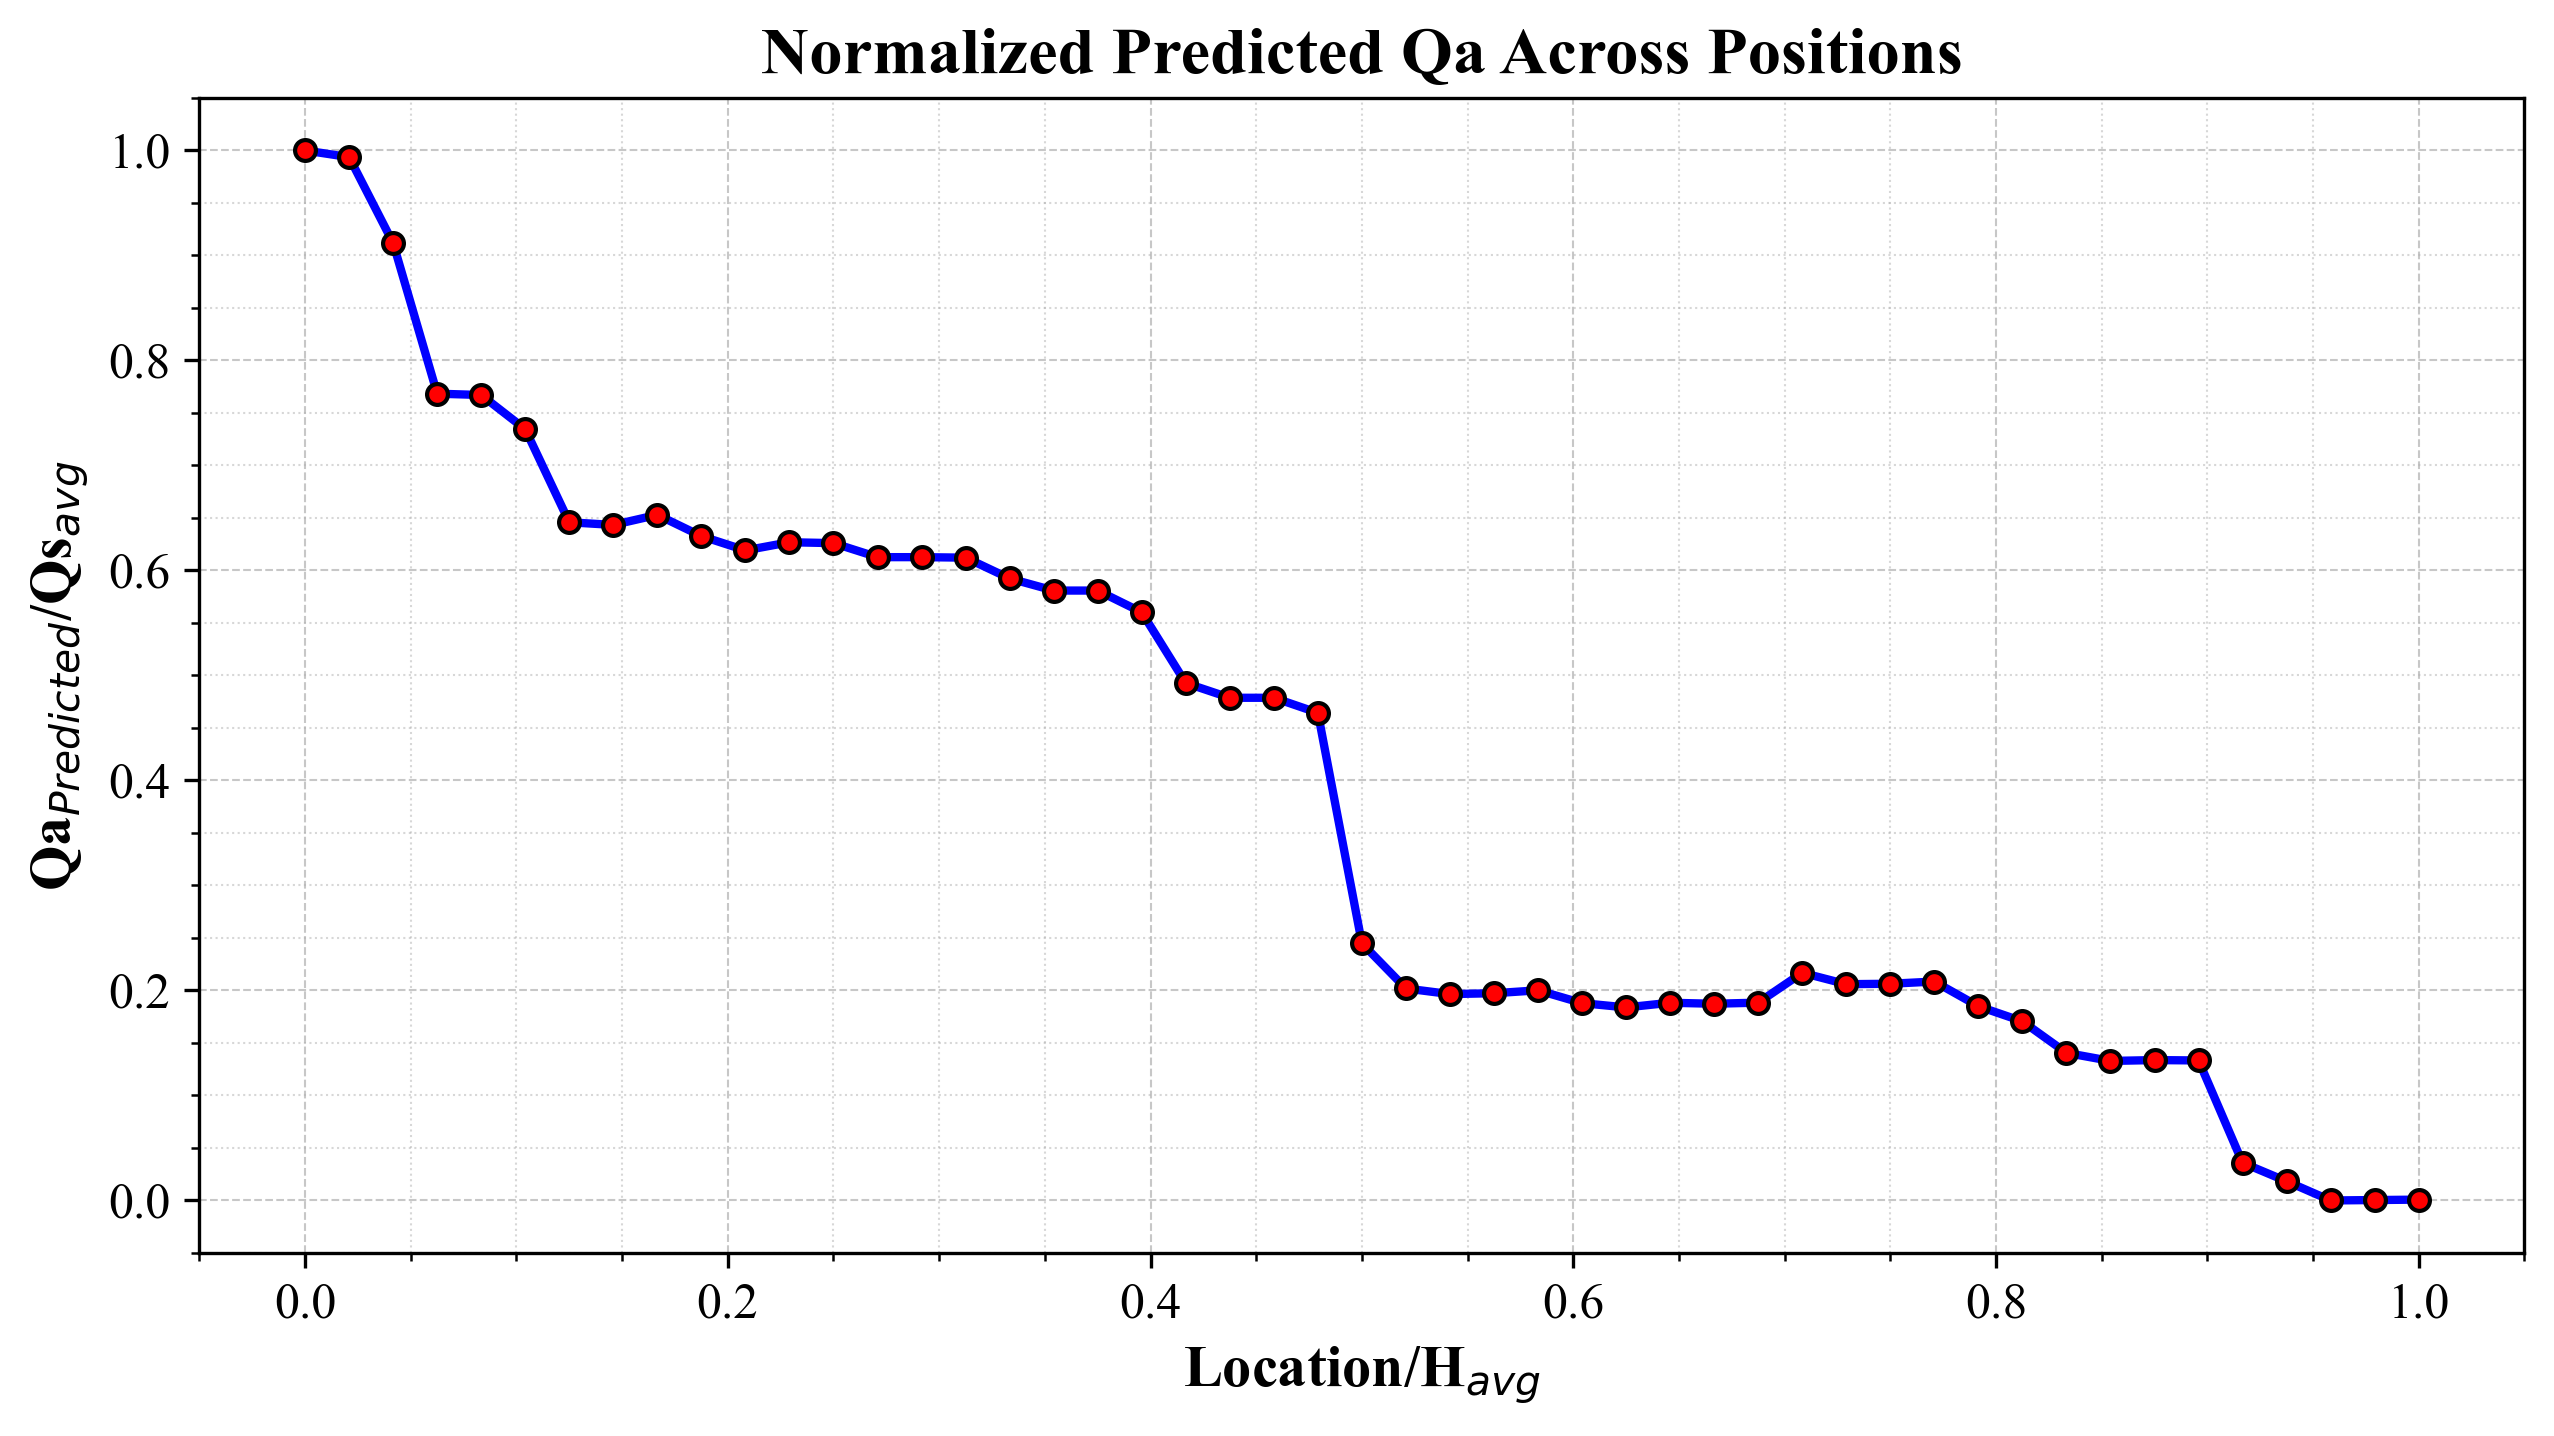

In [20]:
# Create the figure and axis with specified size and resolution
plt.figure(figsize=(10, 5), dpi=300)

# Plot the data with enhancements
plt.plot(results_df['Normalized Position/H_avg'], results_df['Normalized Qa_Predicted (avg)/Qs_avg'], 
         linestyle='-', 
         color='b', 
         linewidth=2,  # Thicker line for better visibility
         marker='o',  # Add markers at data points
         markersize=5,  # Size of markers
         markerfacecolor='r',  # Fill color of the markers
         markeredgewidth=1,  # Edge width of the markers
         markeredgecolor='k'  # Edge color of the markers
        )

# Title of the plot
plt.title('Normalized Predicted Qa Across Positions', fontsize=16, fontname='Times New Roman', fontweight='bold')

# X-axis label with subscript
plt.xlabel('Location/H$_{avg}$', fontsize=14, fontname='Times New Roman', fontweight='bold')

# Y-axis label with subscript
plt.ylabel('Qa$_{Predicted}$/Qs$_{avg}$', fontsize=14, fontname='Times New Roman', fontweight='bold')

# Enable grid with customization
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Set the font for the tick labels
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')

# Add minor ticks for better precision
plt.minorticks_on()

# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Display the plot
plt.show()


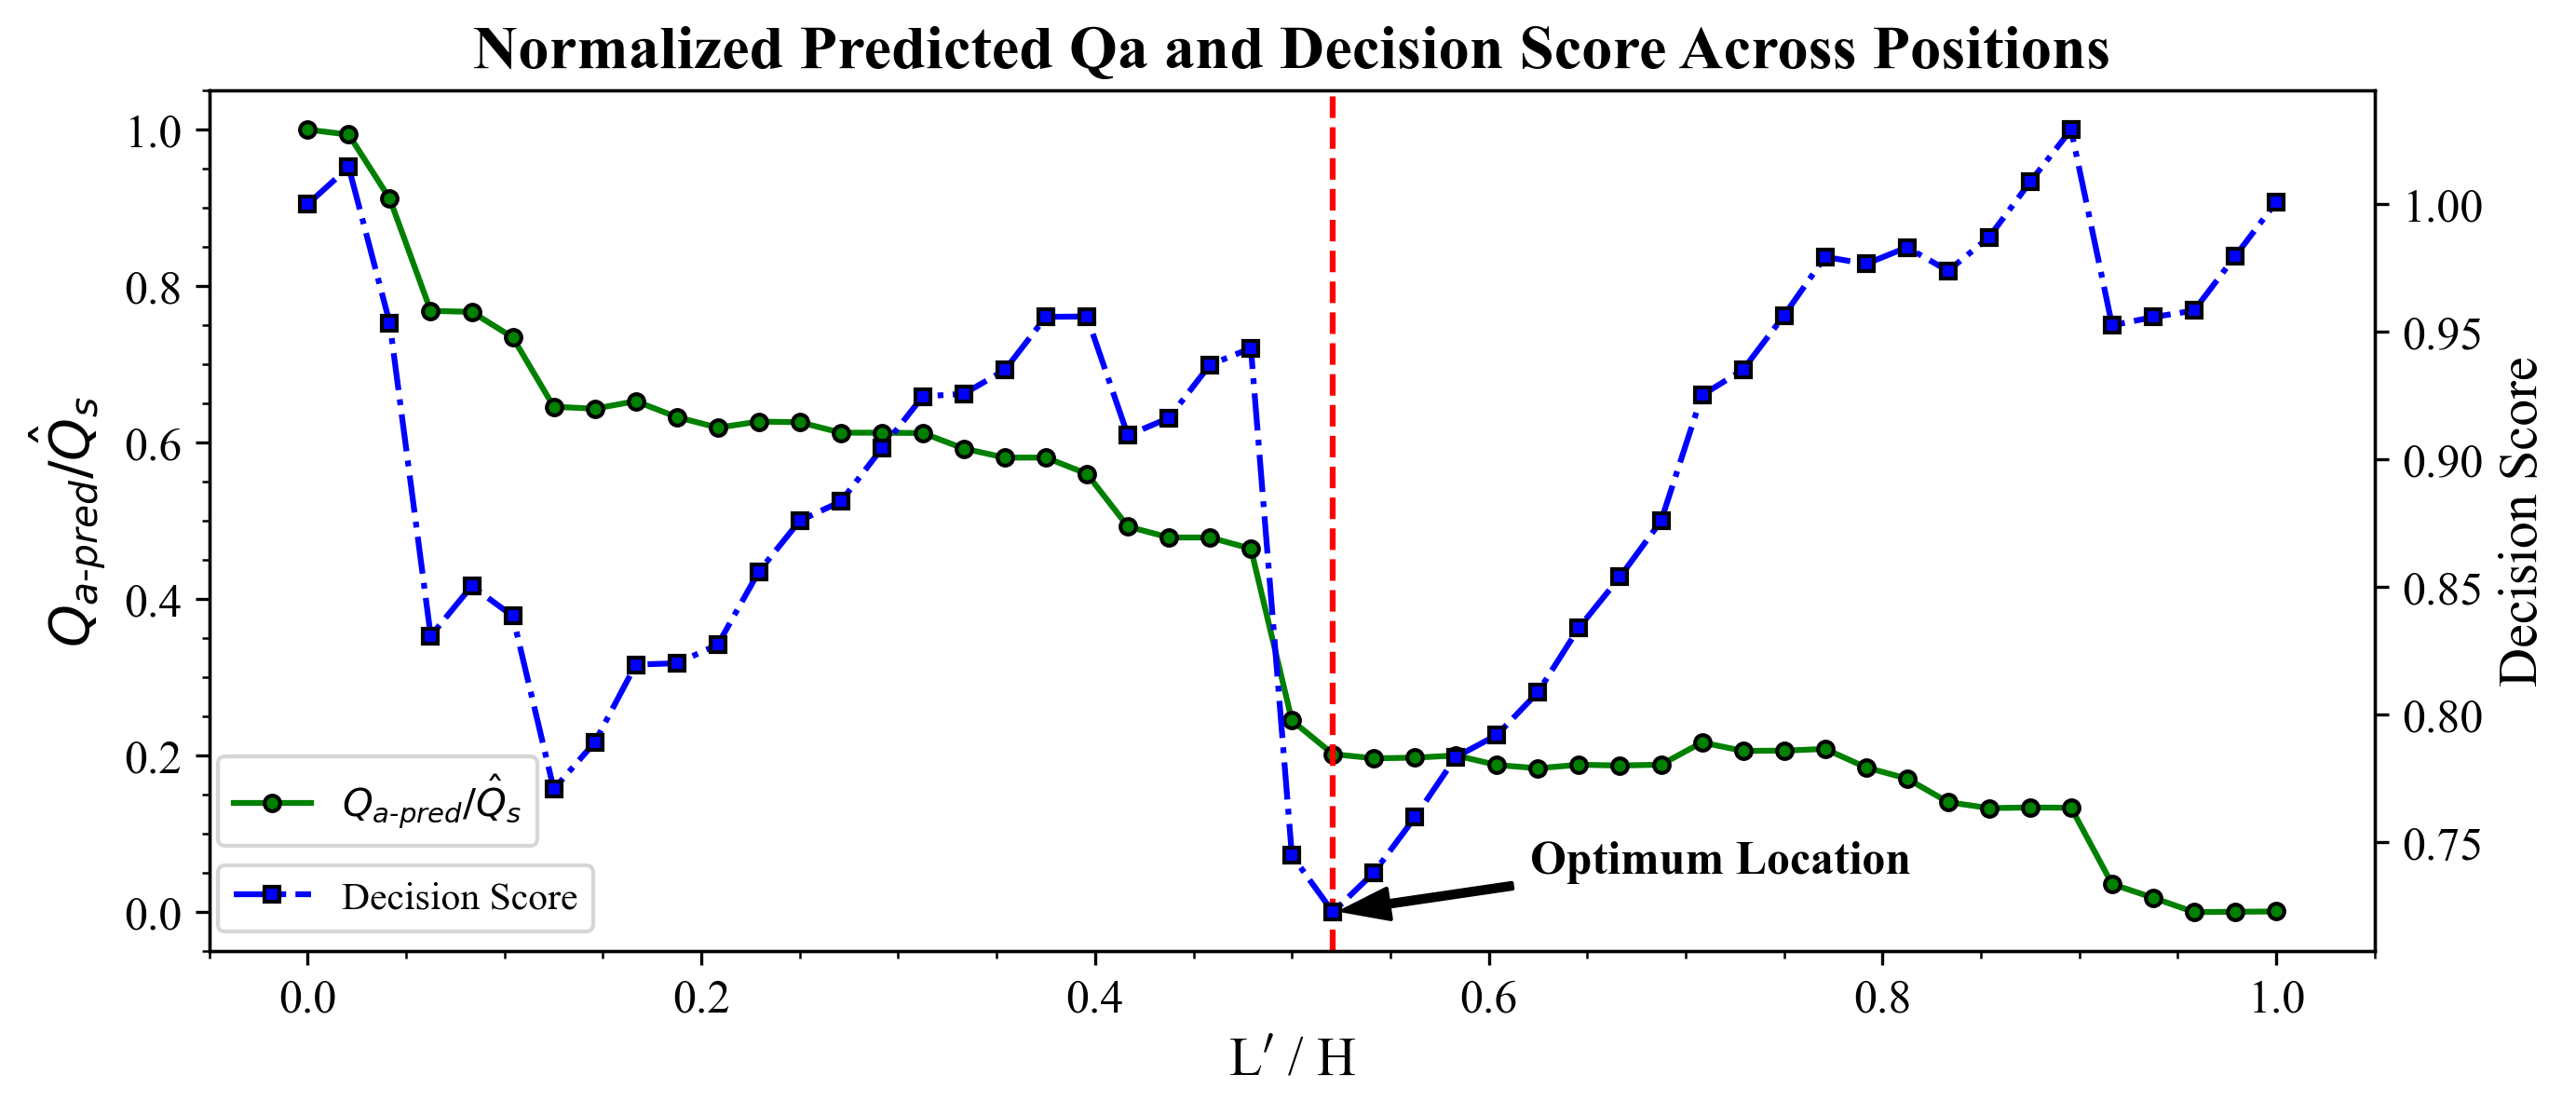

In [21]:
import matplotlib.pyplot as plt

# Set all fonts globally to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Find the index of the minimum value in the 'Decision Score' data
min_decision_score_idx = results_df['Decision Score'].idxmin()

# Get the corresponding 'Normalized Position/H_avg' for the minimum 'Decision Score'
min_position = results_df['Normalized Position/H_avg'].iloc[min_decision_score_idx]


# Create the figure and axis with specified size and resolution
fig, ax1 = plt.subplots(figsize=(10, 4), dpi=300)

# Plot the data on the primary y-axis
ax1.plot(results_df['Normalized Position/H_avg'], results_df['Normalized Qa_Predicted (avg)/Qs_avg'], 
         linestyle='-', 
         color='g', 
         linewidth=1.5,  # Thicker line for better visibility
         marker='o',  # Add markers at data points
         markersize=4,  # Size of markers
         markerfacecolor='g',  # Fill color of the markers
         markeredgewidth=1,  # Edge width of the markers
         markeredgecolor='k',  # Edge color of the markers
         label='$Q_{a\\text{-}pred}/\\hat{Q}_s$'  # Add label for legend
        )

# Title of the plot
ax1.set_title('Normalized Predicted Qa and Decision Score Across Positions', fontsize=16, fontweight='bold')

# X-axis label with subscript
ax1.set_xlabel("L$'$ / H", fontsize=14)

# Y-axis label with subscript for the primary y-axis
ax1.set_ylabel('$Q_{a\\text{-}pred}/\\hat{Q}_s$', fontsize=14, fontweight='bold')

# Set the font for the tick labels on the primary y-axis
ax1.tick_params(axis='y', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Add a vertical dashed line where the Decision Score is the lowest, without adding it to the legend
ax1.axvline(x=min_position, color='r', linestyle='--', linewidth=1.5, label='_nolegend_')

# Add annotation with an arrow pointing to the red line
ax1.annotate('Optimum Location',  # Changed to "Optimum: Location"
             xy=(min_position, results_df['Normalized Qa_Predicted (avg)/Qs_avg'].min()),  # Pointing to the vertical line
             xytext=(min_position + 0.1, results_df['Normalized Qa_Predicted (avg)/Qs_avg'].min() + 0.05),  # Offset for the label
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
             fontsize=12, fontweight='bold')

# Add minor ticks for better precision
ax1.minorticks_on()

# Create a secondary y-axis (right-hand side) that shares the same x-axis
ax2 = ax1.twinx()

# Plot the 'Decision Score' data on the secondary y-axis using the bluesky color
ax2.plot(results_df['Normalized Position/H_avg'], results_df['Decision Score'], 
         linestyle='-.', 
         color='b',  # Use bluesky color
         linewidth=1.5,  # Thicker line for better visibility
         marker='s',  # Add markers at data points
         markersize=4,  # Size of markers
         markerfacecolor='b',  # Fill color of the markers
         markeredgewidth=1,  # Edge width of the markers
         markeredgecolor='k',  # Edge color of the markers
         label='Decision Score'  # Add label for legend
        )

# Y-axis label for the secondary y-axis
ax2.set_ylabel('Decision Score', fontsize=14)

# Set the font for the tick labels on the secondary y-axis
ax2.tick_params(axis='y', labelsize=12)

# Add the legend for both plots
ax1.legend(loc='lower left', bbox_to_anchor=(-0.005, 0.1))  # Primary y-axis legend
ax2.legend(loc='lower left', bbox_to_anchor=(-0.005, 0))  # Secondary y-axis legend with a slight shift


# Display the plot
plt.show()


#### Additional Tips

Data Analysis: Use data analysis techniques to understand dependencies and sensitivities in model outputs.
This process provides a structured approach to using Bayesian Optimization for improving the performance of air bubble curtains based on the dynamics described by the Froude numbers.

# More range for optimization

In [22]:
import pandas as pd
import numpy as np



results_df['Normalized Position/H_avg'] = (results_df['A'] - results_df['A'].min()) / (results_df['A'].max() - results_df['A'].min())
results_df['Normalized Qa_Predicted (avg)/Qs_avg'] = (results_df['B'] - results_df['B'].min()) / (results_df['B'].max() - results_df['B'].min())



# Generate decision scores for varying weights
weights = np.arange(0, 1.05, 0.1)
optimal_positions = []

# Varying the weight of Normalized Position from 0 to 1, keeping Normalized Qa_Predicted at 1
for weight_pos in weights:
    weight_qa = 1
    decision_score_col = f'Decision Score (Pos={weight_pos:.2f}, Qa={weight_qa:.2f})'
    results_df[decision_score_col] = (results_df['Normalized Position/H_avg'] * weight_pos) + (results_df['Normalized Qa_Predicted (avg)/Qs_avg'] * weight_qa)
    
    # Find the position with the lowest decision score for the current weight
    optimal_position = results_df.loc[results_df[decision_score_col].idxmin()]
    optimal_positions.append({
        'Position Weight': weight_pos,
        'Qa Weight': weight_qa,
        'Position': optimal_position['Location'],
        'Predicted ABC': optimal_position['ABC'],
        'Normalized Position': optimal_position['Normalized Position/H_avg'],
        'Normalized Qa_Predicted': optimal_position['Normalized Qa_Predicted (avg)/Qs_avg'],
        'Decision Score': optimal_position[decision_score_col]
    })

# Varying the weight of Normalized Qa_Predicted from 0 to 1, keeping Normalized Position at 1
for weight_qa in weights:
    weight_pos = 1
    decision_score_col = f'Decision Score (Pos={weight_pos:.2f}, Qa={weight_qa:.2f})'
    results_df[decision_score_col] = (results_df['Normalized Position/H_avg'] * weight_pos) + (results_df['Normalized Qa_Predicted (avg)/Qs_avg'] * weight_qa)
    
    # Find the position with the lowest decision score for the current weight
    optimal_position = results_df.loc[results_df[decision_score_col].idxmin()]
    optimal_positions.append({
        'Qa Weight': weight_qa,
        'Position Weight': weight_pos,
        'Position': optimal_position['Location'],
        'Predicted ABC': optimal_position['ABC'],
        'Normalized Position': optimal_position['Normalized Position/H_avg'],
        'Normalized Qa_Predicted': optimal_position['Normalized Qa_Predicted (avg)/Qs_avg'],
        'Decision Score': optimal_position[decision_score_col]
    })

# Combine the optimal positions into a DataFrame
optimal_positions_df = pd.DataFrame(optimal_positions)

# Display the DataFrame
optimal_positions_df.head(4)


,Position Weight,Qa Weight,Position,Predicted ABC,Normalized Position,Normalized Qa_Predicted,Decision Score
0,0.0,1.0,97.0,0.340595,0.958333,0.0,0.000000
1,0.1,1.0,97.0,0.340595,0.958333,0.0,0.095833
2,0.2,1.0,97.0,0.340595,0.958333,0.0,0.191667
3,0.3,1.0,97.0,0.340595,0.958333,0.0,0.287500


In [23]:
import pandas as pd
import numpy as np

# Normalize the metrics (scale between 0 and 1)
results_df['Normalized Position/H_avg'] = (results_df['A'] - results_df['A'].min()) / (results_df['A'].max() - results_df['A'].min())
results_df['Normalized Qa_Predicted (avg)/Qs_avg'] = (results_df['B'] - results_df['B'].min()) / (results_df['B'].max() - results_df['B'].min())

# Generate decision scores for varying weights
weights = np.arange(0, 1.05, 0.1)
optimal_positions = []

# Varying the weight of Normalized Position from 0 to 1, keeping Normalized Qa_Predicted at 1
for weight_pos in weights:
    weight_qa = 1
    decision_score_col = f'Decision Score (Pos={weight_pos:.2f}, Qa={weight_qa:.2f})'
    results_df[decision_score_col] = (results_df['Normalized Position/H_avg'] * weight_pos) + (results_df['Normalized Qa_Predicted (avg)/Qs_avg'] * weight_qa)
    
    # Find the position with the lowest decision score for the current weight
    optimal_position = results_df.loc[results_df[decision_score_col].idxmin()]
    optimal_positions.append({
        'Position Weight': weight_pos,
        'Qa Weight': weight_qa,
        'Position': optimal_position['Location'],
        'Predicted ABC': optimal_position['ABC'],
        'Normalized Position': optimal_position['Normalized Position/H_avg'],
        'Normalized Qa_Predicted': optimal_position['Normalized Qa_Predicted (avg)/Qs_avg'],
        'Decision Score': optimal_position[decision_score_col],
        'A': optimal_position['A'],
        'B': optimal_position['B']
    })

# Varying the weight of Normalized Qa_Predicted from 0 to 1, keeping Normalized Position at 1
for weight_qa in weights:
    weight_pos = 1
    decision_score_col = f'Decision Score (Pos={weight_pos:.2f}, Qa={weight_qa:.2f})'
    results_df[decision_score_col] = (results_df['Normalized Position/H_avg'] * weight_pos) + (results_df['Normalized Qa_Predicted (avg)/Qs_avg'] * weight_qa)
    
    # Find the position with the lowest decision score for the current weight
    optimal_position = results_df.loc[results_df[decision_score_col].idxmin()]
    optimal_positions.append({
        'Qa Weight': weight_qa,
        'Position Weight': weight_pos,
        'Position': optimal_position['Location'],
        'Predicted ABC': optimal_position['ABC'],
        'Normalized Position': optimal_position['Normalized Position/H_avg'],
        'Normalized Qa_Predicted': optimal_position['Normalized Qa_Predicted (avg)/Qs_avg'],
        'Decision Score': optimal_position[decision_score_col],
        'A': optimal_position['A'],
        'B': optimal_position['B']
    })

# Combine the optimal positions into a DataFrame
optimal_positions_df = pd.DataFrame(optimal_positions)

# Display the DataFrame
optimal_positions_df.head(4)


,Position Weight,Qa Weight,Position,Predicted ABC,Normalized Position,Normalized Qa_Predicted,Decision Score,A,B
0,0.0,1.0,97.0,0.340595,0.958333,0.0,0.000000,4.041667,0.204316
1,0.1,1.0,97.0,0.340595,0.958333,0.0,0.095833,4.041667,0.204316
2,0.2,1.0,97.0,0.340595,0.958333,0.0,0.191667,4.041667,0.204316
3,0.3,1.0,97.0,0.340595,0.958333,0.0,0.287500,4.041667,0.204316


In [24]:
df_1=optimal_positions_df.iloc[1:11]
#df_1.head()


df_2=optimal_positions_df.iloc[12:]



# Save the DataFrame to an Excel file
file_path = 'Decision Making_results_df_1.xlsx'
df_1.to_excel(file_path, index=False)

file_path = 'Decision Making_results_df_2.xlsx'
df_2.to_excel(file_path, index=False)


df_2.head(20)

,Position Weight,Qa Weight,Position,Predicted ABC,Normalized Position,Normalized Qa_Predicted,Decision Score,A,B
12,1.0,0.1,51.0,0.390969,0.000000,1.000000,0.100000,2.125000,0.234534
13,1.0,0.2,51.0,0.390969,0.000000,1.000000,0.200000,2.125000,0.234534
14,1.0,0.3,54.0,0.379301,0.062500,0.768373,0.293012,2.250000,0.227535
15,1.0,0.4,54.0,0.379301,0.062500,0.768373,0.369849,2.250000,0.227535
16,1.0,0.5,54.0,0.379301,0.062500,0.768373,0.446687,2.250000,0.227535
17,1.0,0.6,57.0,0.373131,0.125000,0.645883,0.512530,2.375000,0.223834
18,1.0,0.7,57.0,0.373131,0.125000,0.645883,0.577118,2.375000,0.223834
19,1.0,0.8,57.0,0.373131,0.125000,0.645883,0.641706,2.375000,0.223834
20,1.0,0.9,76.0,0.350765,0.520833,0.201888,0.702533,3.166667,0.210417
21,1.0,1.0,76.0,0.350765,0.520833,0.201888,0.722721,3.166667,0.210417


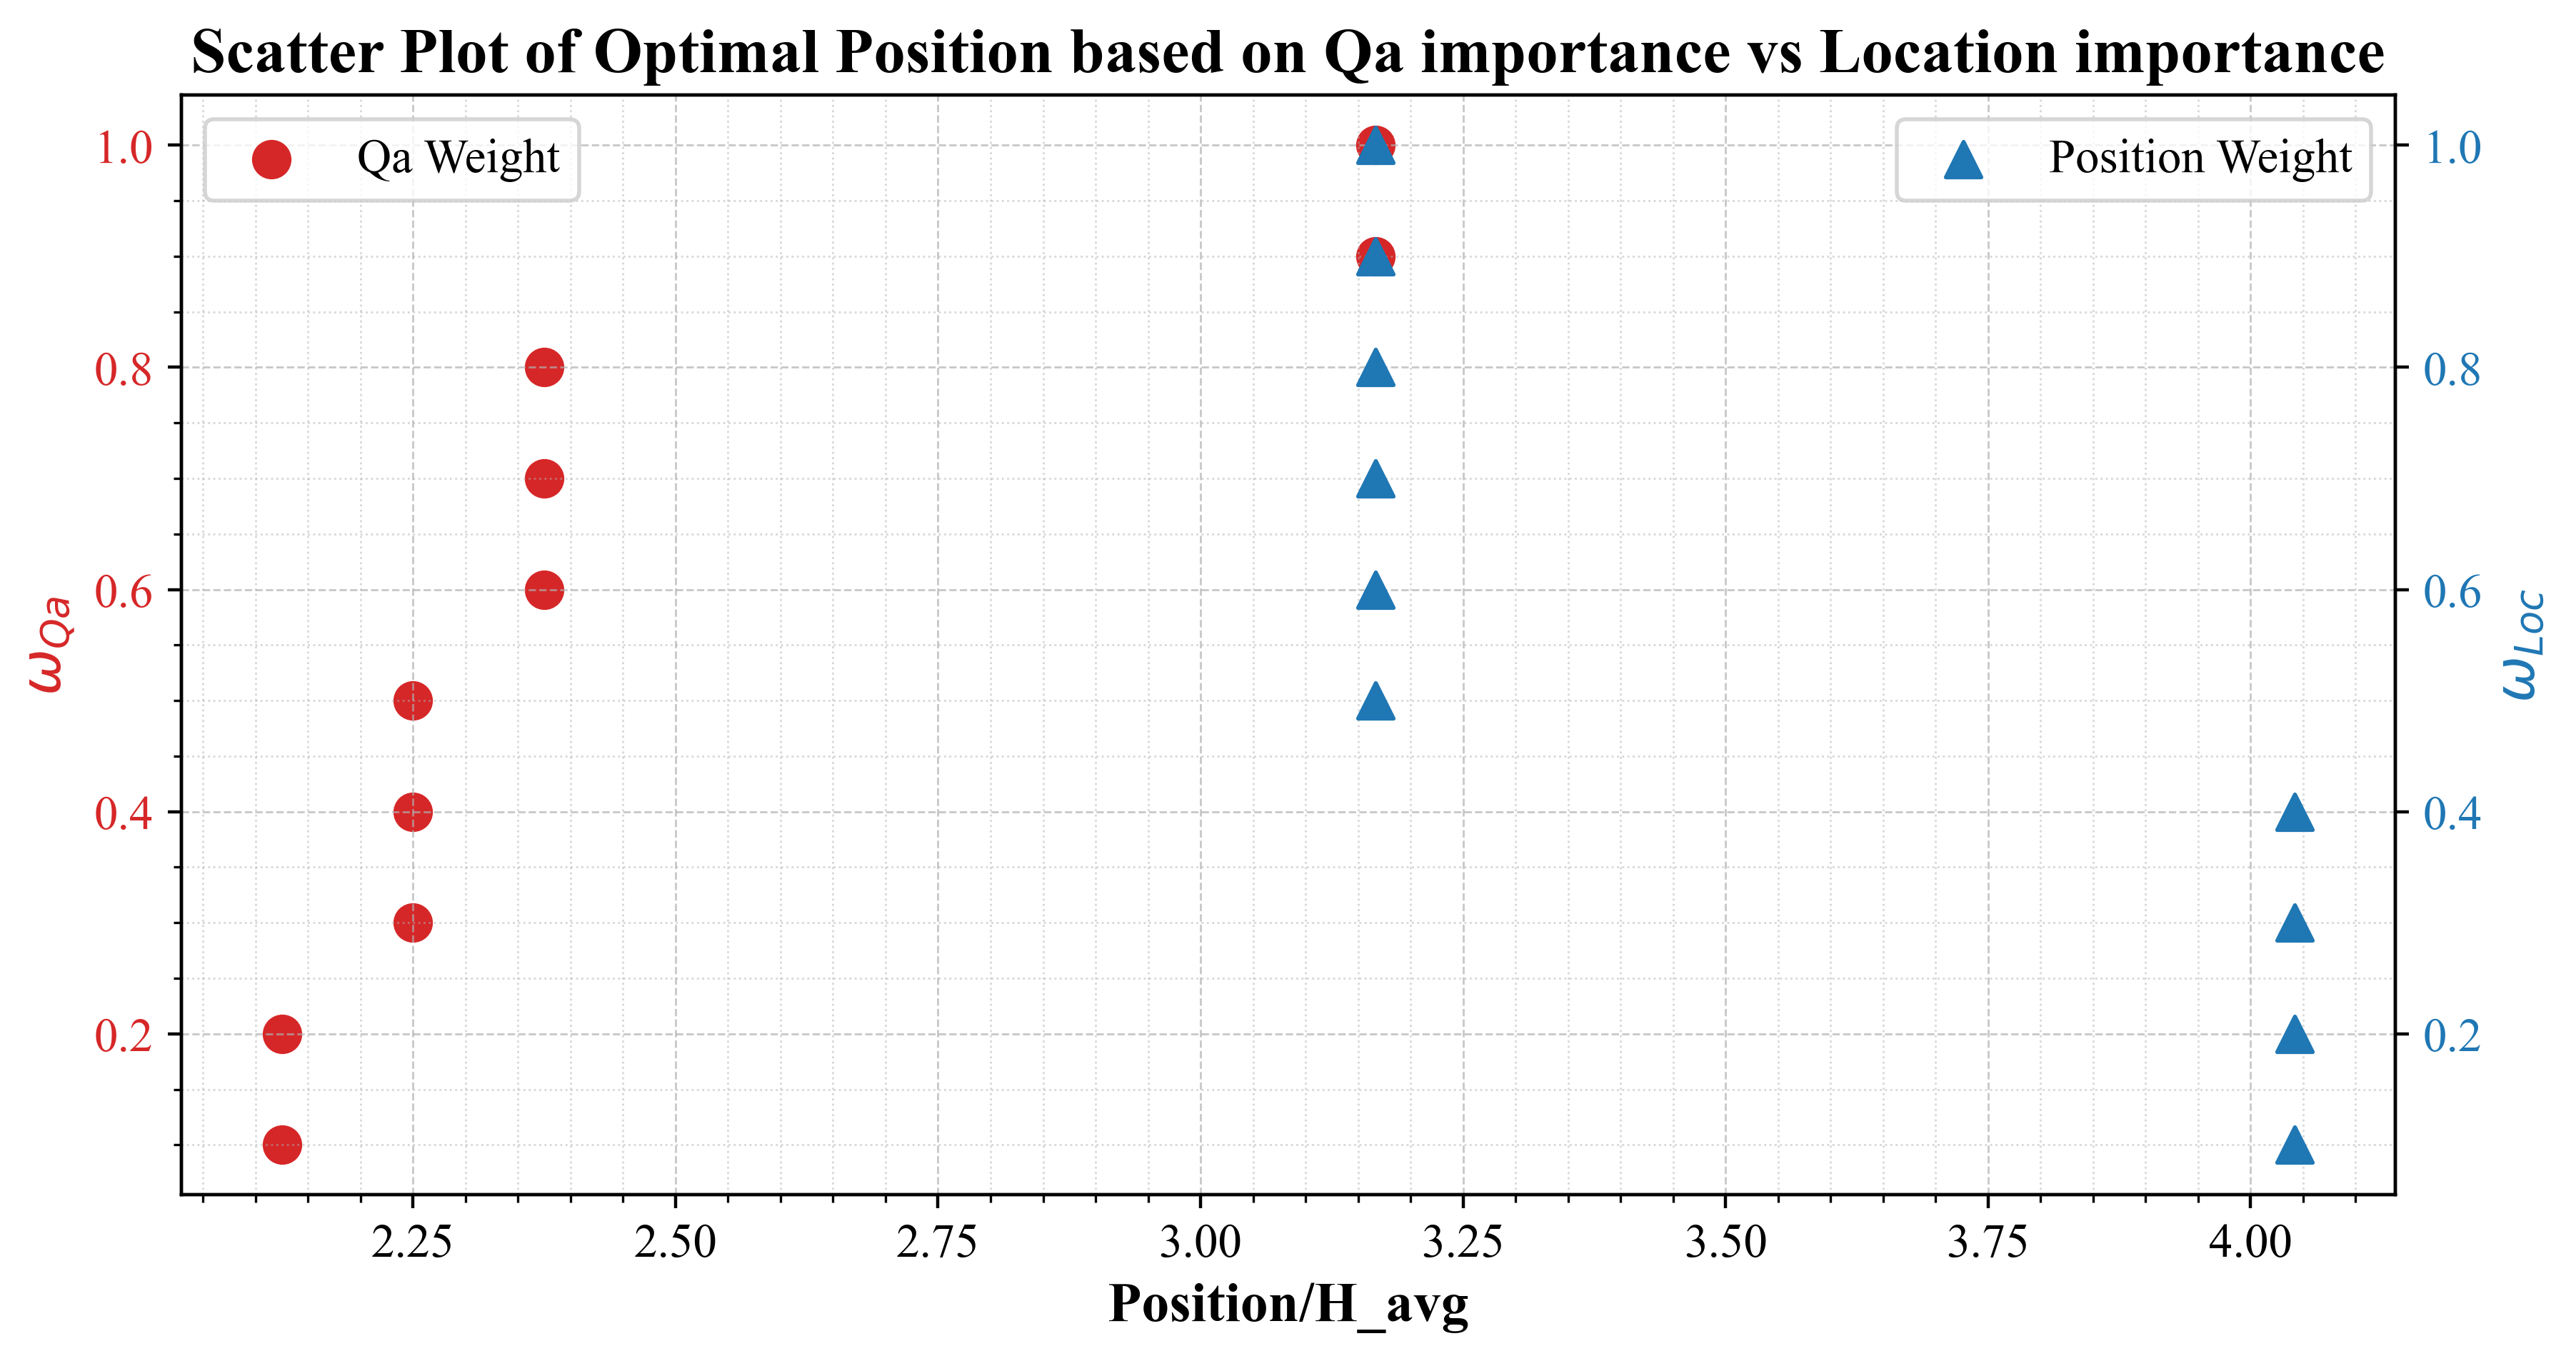

In [25]:
################## plotting ######################

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


# Setting the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create the figure and axis with specified size and resolution
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=400)

Omega_Qa = r'$\omega_{Qa}$'
Omega_Loc = r'$\omega_{Loc}$'


# Primary y-axis
color = 'tab:red'
ax1.set_xlabel('Position/H_avg', fontweight='bold', fontsize=14)
ax1.set_ylabel(f'{Omega_Qa}', color=color, fontweight='bold', fontsize=14)
ax1.scatter(df_2['A'], df_2['Qa Weight'], color=color, label='Qa Weight', marker='o', s=80)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Secondary y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(f'{Omega_Loc}', color=color, fontweight='bold', fontsize=14)
ax2.scatter(df_1['A'], df_1['Position Weight'], color=color, label='Position Weight', marker='^', s=80)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)


"""
# Define x, y1, and y2 for smoothing (example values, replace with your data)
x = df_2['A']
y1 = df_2['Qa Weight']
y2 = df_1['Position Weight']

# Create smooth curves using make_interp_spline
x_smooth = np.linspace(x.min(), x.max(), 500)
spl1 = make_interp_spline(x, y1, k=3)
spl2 = make_interp_spline(x, y2, k=3)
y_smooth1 = spl1(x_smooth)
y_smooth2 = spl2(x_smooth)

# Fill between for smooth boundaries
ax1.fill_between(x_smooth, y_smooth1, y_smooth2, color='red', alpha=0.3)





# Adding boundary layers
x_boundary = np.linspace(2.2, 4.0, 500)
y_boundary1 = 1 - (x_boundary - 2.2) / 2.0
y_boundary2 = (x_boundary - 2.2) / 2.0

# Fill between for smooth boundaries
ax1.fill_between(x_boundary, 0, y_boundary1, color='red', alpha=0.3)
ax2.fill_between(x_boundary, 0, y_boundary2, color='blue', alpha=0.3)
"""

# Adding title and grid with enhancements
plt.title('Scatter Plot of Optimal Position based on Qa importance vs Location importance', fontsize=16, fontweight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.minorticks_on()
ax1.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Set the font for the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding legends
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Show plot
plt.show()


## for nomalized values:

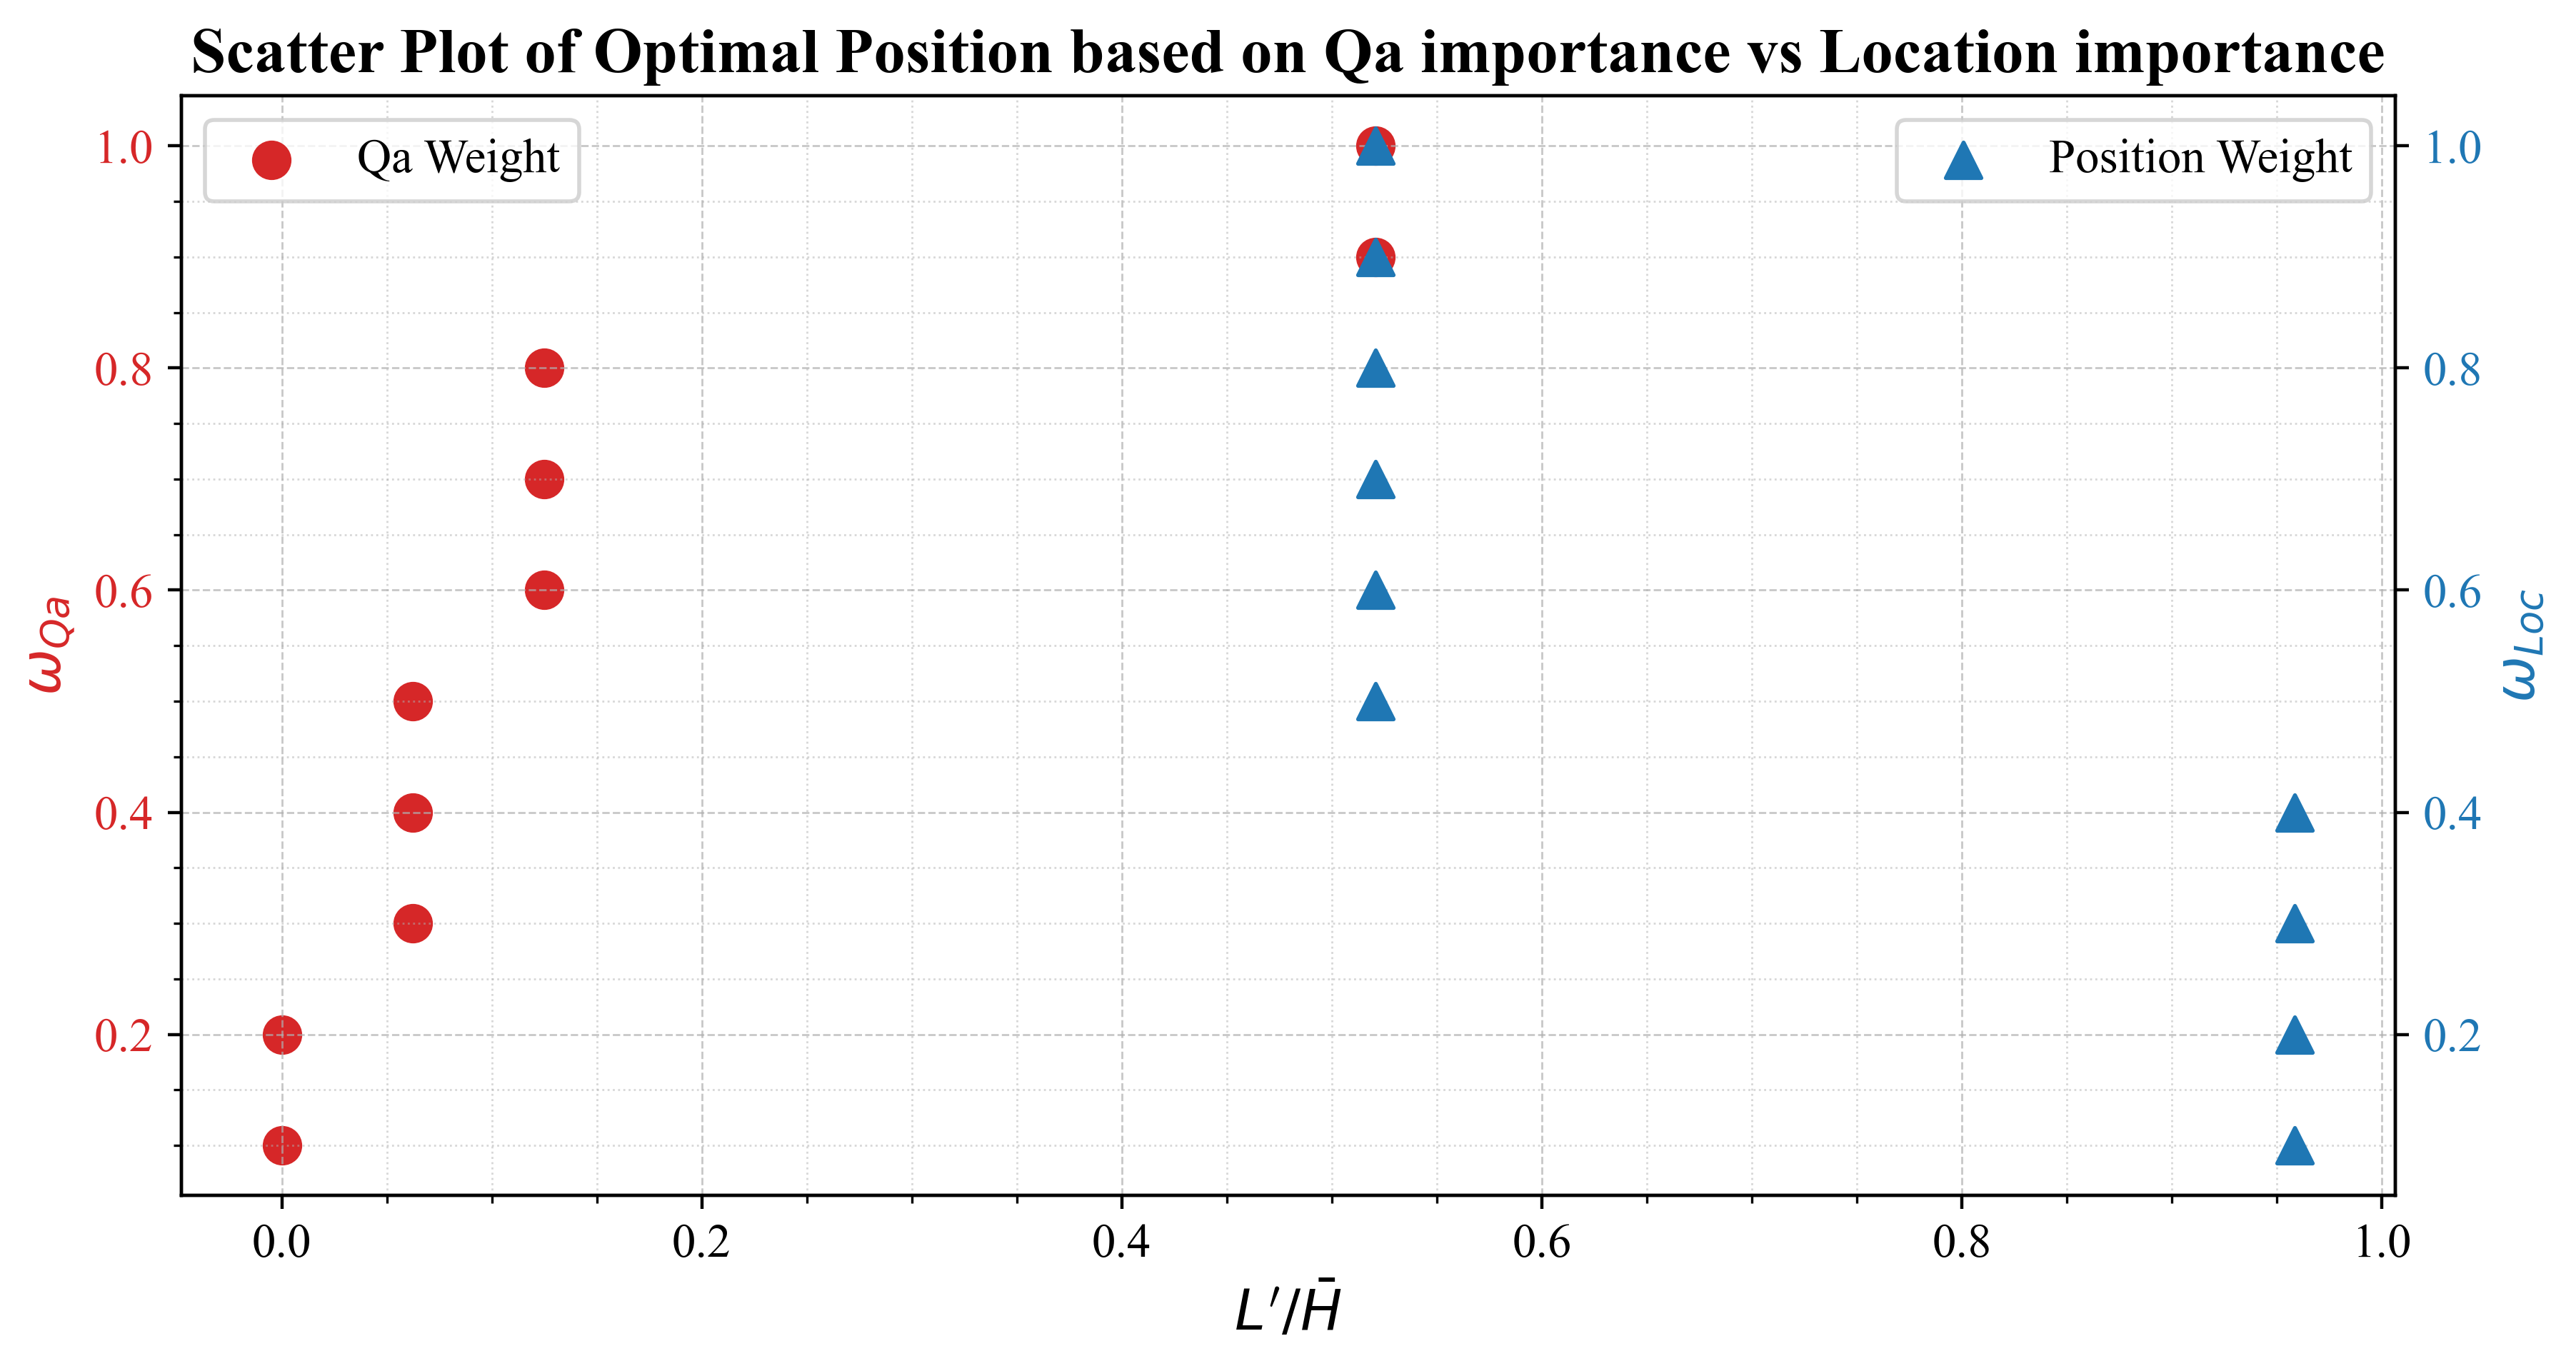

In [26]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

# Setting the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create the figure and axis with specified size and resolution
fig, ax1 = plt.subplots(figsize=(10, 5), dpi=400)

Omega_Qa = r'$\omega_{Qa}$'
Omega_Loc = r'$\omega_{Loc}$'

# Primary y-axis
color = 'tab:red'
#ax1.set_xlabel('Normalized Position/H_avg', fontweight='bold', fontsize=14)
ax1.set_xlabel(r"$L'/\bar{H}$", fontweight='bold', fontsize=14)

ax1.set_ylabel(f'{Omega_Qa}', color=color, fontweight='bold', fontsize=14)
ax1.scatter(df_2['Normalized Position'], df_2['Qa Weight'], color=color, label='Qa Weight', marker='o', s=80)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)

# Secondary y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(f'{Omega_Loc}', color=color, fontweight='bold', fontsize=14)
ax2.scatter(df_1['Normalized Position'], df_1['Position Weight'], color=color, label='Position Weight', marker='^', s=80)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

# Adding title and grid with enhancements
plt.title('Scatter Plot of Optimal Position based on Qa importance vs Location importance', fontsize=16, fontweight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax1.minorticks_on()
ax1.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Set the font for the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding legends
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Show plot
plt.show()


# The End